In [124]:
import pandas as pd
import numpy as np
import statistics as stats

import gurobipy as gp
from gurobipy import GRB

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)

### Preprocessing

In [125]:
### Load Datasets
# Dropna: remove all empty lines - if no salary, the player not available for lineup
QB2021 = pd.read_csv("QB2021.csv").dropna()
QB2021['QB'] = [1] * len(QB2021)

RB2021 = pd.read_csv("RB2021.csv").dropna()
RB2021['RB'] = [1] * len(RB2021)

WR2021 = pd.read_csv("WR2021.csv").dropna()
WR2021['WR'] = [1] * len(WR2021)

TE2021 = pd.read_csv("TE2021.csv").dropna()
TE2021['TE'] = [1] * len(TE2021)

DST2021 = pd.read_csv("DST2021.csv").dropna()
DST2021['DST'] = [1] * len(DST2021)

In [126]:
### Add Fantasy Points rank column
def FPrank(df):
    frames = []
    for i in range(1,18):
        frame = df[df.Week == i].sort_values(by='FantasyPoints', ascending=False)
        frame['FPRank'] = frame['FantasyPoints'].rank(ascending=False, method='min')
        frames.append(frame)
    final = pd.concat(frames)
    return final

QB2021 = FPrank(QB2021)
RB2021 = FPrank(RB2021)
WR2021 = FPrank(WR2021)
TE2021 = FPrank(TE2021)
DST2021 = FPrank(DST2021)

In [127]:
### Add Salary rank column
def Srank(df):
    frames = []
    for i in range(1,18):
        frame = df[df.Week == i].sort_values(by='Salary', ascending=False)
        frame['SRank'] = frame['Salary'].rank(ascending=False, method='min')
        frames.append(frame)
    final = pd.concat(frames)
    return final

QB2021 = Srank(QB2021)
RB2021 = Srank(RB2021)
WR2021 = Srank(WR2021)
TE2021 = Srank(TE2021)
DST2021 = Srank(DST2021)

In [128]:
### Combine all players into 1 dataset
players = (QB2021, RB2021, WR2021, TE2021, DST2021)
all_players = pd.concat(players, ignore_index = True).fillna(0)

In [129]:
### Drop Teams that are not eligible to be in Daily Fantasy Lineups (teams that don't play on Sunday during the day)
teams_not_sunday = [['TB','PHI','SEA','PIT','BUF','TEN'],
    ['DEN','CLE','IND','SF','NO','SEA'],
    ['GB','ARI','DAL','MIN','NYG','KC'],
    ['NYJ','IND','TEN','LAR','CHI','PIT'],
    ['BAL','MIA','KC','LV','LAR','SF'],
    ['NE','ATL','PIT','LAC','NYG','TB'],
    ['CHI','DET','LV','DAL','BUF','NO','CLE','BAL','SEA','WAS'], # more teams because of thanksgiving thursday games
    ['DAL','NO','DEN','KC','NE','BUF'],
    ['PIT','MIN','CHI','GB','LAR','ARI'],
    ['KC','LAC','NE','IND','NO','TB','LV','CLE','MIN','CHI','SEA','LAR','WAS','PHI'], # more games because of saturday, monday, and tuesday games
    ['SF','TEN','CLE','GB','IND','ARI','WAS','DAL','MIA','NO'], # more games due to christmas
    ['MIN','GB','CLE','PIT']]# less game because no thursday

for (week_i,list_j) in zip(range(6,18),teams_not_sunday):
    
    rows = all_players[(all_players.Week == week_i)&(all_players.Team.isin(list_j))].index.to_list()
    all_players = all_players.drop(rows)


In [130]:
fantasy_points_all_models = []

###  Using Our Predictions and No Additonal Constraints

In [131]:
### Function: Optimization model that selects best fantasy football lineup
def optimize_week(weeknum):

    m = gp.Model()

    # add binary variables for every player in week i
    players_temp = all_players[all_players.Week ==weeknum]
    keys = [*range(0, len(players_temp))]
    players_temp.index = keys

    # define variables
    player = m.addVars(len(players_temp), vtype=GRB.BINARY, name='player')
    cost = players_temp.Salary
    points = players_temp.FantasyPoints_OurPrediction 
    qb = players_temp.QB
    rb = players_temp.RB
    wr = players_temp.WR
    te = players_temp.TE
    dst = players_temp.DST

    ### Objective Function: Maximize Fantasy League Points
    length = len(players_temp)
    m.setObjective((gp.quicksum(points[x] * player[x] for x in range(length))), GRB.MAXIMIZE)

    ### Constraint 1: Positions
    # 1 QB
    m.addConstr(1 == gp.quicksum(player[x]*qb[x] for x in range(length)))

    # 2 RB (and FB) 
    m.addConstr(2 == sum(player[x]*rb[x] for x in range(length)))

    # 1 TE
    m.addConstr(1 == gp.quicksum(player[x]*te[x] for x in range(length)))

    # 1 DST (Defense)
    m.addConstr(1 == gp.quicksum(player[x]*dst[x] for x in range(length)))

    # WR constraint defined later in the code (see constraint 5)
    # total 9 players
    m.addConstr(9 == gp.quicksum(player[x]*qb[x] + player[x]*rb[x] + player[x]*wr[x] + 
    player[x]*te[x] + player[x]*dst[x] for x in range(length)))

    ### Constraint 2: Budget
    # Total team budget for each week cannot exceed $50,000
    m.addConstr(50000 >= gp.quicksum(player[x]*cost[x] for x in range(length)))

    status = m.optimize()

    # Output and analysis
    ObjectiveValue=m.objVal

    #The optimal solution consists of the following
    dict_week_i = []
    for v in m.getVars():
        if v.x == 1: 
            # extract number (aka key) from variable name
            one = v.VarName.index('[')
            two = v.VarName.index(']')
            temp = int(v.VarName[one+1:two])

            row_player = players_temp.loc[[0]]
           
            dict_player_v = {"FPRank": players_temp.FPRank[temp],
                             "SRank": players_temp.SRank[temp],
                             "Name": players_temp.Name[temp],
                             "Position": players_temp.Position[temp],
                             "Week": players_temp.Week[temp],
                             "Team": players_temp.Team[temp],
                             "Opponent": players_temp.Opponent[temp],
                             "Salary": players_temp.Salary[temp],
                             "FantasyPoints": players_temp.FantasyPoints[temp]}

            dict_week_i.append(dict_player_v)

    df_week_i = pd.DataFrame(dict_week_i)
    
    position_categories = ["QB", "RB", "WR", "TE", "FLEX", "DST"] 
    df_week_i["Position"] = pd.Categorical(df_week_i["Position"], categories = position_categories)
    df_week_i.sort_values(by = "Position")
    
    return df_week_i

In [132]:
### Run the optimization model on weeks 6-17
dfs = []
for i in range(6,18):
    df = optimize_week(i)
    dfs.append(df)

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 6 rows, 236 columns and 624 nonzeros
Model fingerprint: 0xf0db5ffb
Variable types: 0 continuous, 236 integer (236 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+03]
  Objective range  [2e-01, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+04]
Found heuristic solution: objective 83.9758925
Presolve removed 0 rows and 71 columns
Presolve time: 0.00s
Presolved: 6 rows, 165 columns, 330 nonzeros
Found heuristic solution: objective 136.6650606
Variable types: 0 continuous, 165 integer (164 binary)
Found heuristic solution: objective 141.2392307

Root relaxation: objective 1.505120e+02, 9 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 


Cutting planes:
  Gomory: 1
  GUB cover: 1

Explored 1 nodes (23 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 6: 137.732 137.629 137.491 ... 92.1115

Optimal solution found (tolerance 1.00e-04)
Best objective 1.377321449221e+02, best bound 1.377321449221e+02, gap 0.0000%
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 6 rows, 274 columns and 719 nonzeros
Model fingerprint: 0xb39e5fde
Variable types: 0 continuous, 274 integer (274 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+03]
  Objective range  [2e-03, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+04]
Found heuristic solution: objective 96.2585872
Presolve removed 0 rows and 83 columns
Presolve time: 0.00s
Presolved: 6 rows, 191 columns, 382 nonzeros
Found heuristic solution: objective 127.3401058
Variable t


Solution count 5: 137.071 133.916 124.558 ... 69.4658

Optimal solution found (tolerance 1.00e-04)
Best objective 1.370714995138e+02, best bound 1.370714995138e+02, gap 0.0000%
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 6 rows, 266 columns and 701 nonzeros
Model fingerprint: 0x51e72bae
Variable types: 0 continuous, 266 integer (266 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+03]
  Objective range  [4e-02, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+04]
Found heuristic solution: objective 78.1516265
Presolve removed 0 rows and 80 columns
Presolve time: 0.00s
Presolved: 6 rows, 186 columns, 372 nonzeros
Found heuristic solution: objective 135.0267398
Variable types: 0 continuous, 186 integer (186 binary)
Found heuristic solution: objective 145.0248027

Root relaxation: objective 1.550222e+02, 11 iterations, 0.00 seconds (0.0

In [133]:
### Ouputs selected lineups for each week and stores total fantasy points for each week in a list
fantasy_points_this_model = []
for i in range(0,len(dfs)):
    display(dfs[i])
    fantasy_points_this_model.append(dfs[i].FantasyPoints.sum())
fantasy_points_all_models.append(fantasy_points_this_model)

,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,23.0,16.0,Taylor Heinicke,QB,6,WAS,KC,5800,10.28
1,23.0,2.0,Austin Ekeler,RB,6,LAC,BAL,7900,9.50
2,11.0,9.0,James Robinson,RB,6,JAX,MIA,6300,19.10
3,21.0,12.0,Ja'Marr Chase,WR,6,CIN,DET,6700,13.70
4,46.0,21.0,Marquise Brown,WR,6,BAL,LAC,5900,7.50
5,16.0,22.0,Brandin Cooks,WR,6,HOU,IND,5800,17.90
6,17.0,43.0,Darnell Mooney,WR,6,CHI,GB,4300,15.50
7,4.0,3.0,Mark Andrews,TE,6,BAL,LAC,5200,17.80
8,18.0,26.0,Detroit Lions,DST,6,DET,CIN,2100,3.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,21.0,11.0,Sam Darnold,QB,7,CAR,NYG,5900,3.48
1,13.0,1.0,Derrick Henry,RB,7,TEN,KC,9200,16.40
2,28.0,5.0,Darrell Henderson Jr.,RB,7,LAR,DET,6600,9.40
3,11.0,17.0,Marquise Brown,WR,7,BAL,CIN,5800,19.00
4,16.0,18.0,Jaylen Waddle,WR,7,MIA,ATL,5600,15.30
5,39.0,33.0,Darnell Mooney,WR,7,CHI,TB,4600,5.90
6,70.0,40.0,Amon-Ra St. Brown,WR,7,DET,LAR,4100,0.00
7,17.0,2.0,Mark Andrews,TE,7,BAL,CIN,6000,7.80
8,3.0,24.0,Tennessee Titans,DST,7,TEN,KC,2100,17.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,26.0,13.0,Matt Ryan,QB,8,ATL,CAR,5900,8.14
1,41.0,1.0,Derrick Henry,RB,8,TEN,IND,8900,6.80
2,45.0,11.0,James Robinson,RB,8,JAX,SEA,6600,4.90
3,8.0,9.0,Deebo Samuel,WR,8,SF,CHI,7400,26.10
4,19.0,16.0,Diontae Johnson,WR,8,PIT,CLE,6700,15.80
5,12.0,25.0,Brandin Cooks,WR,8,HOU,LAR,5700,20.30
6,45.0,61.0,Deonte Harris,WR,8,NO,TB,3600,8.70
7,23.0,21.0,Cole Kmet,TE,8,CHI,SF,3100,5.40
8,13.0,29.0,Washington Commanders,DST,8,WAS,DEN,2100,7.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,16.0,1.0,Josh Allen,QB,9,BUF,JAX,8200,12.56
1,14.0,15.0,Devontae Booker,RB,9,NYG,LV,5900,15.20
2,19.0,16.0,Elijah Mitchell,RB,9,SF,ARI,5800,12.90
3,23.0,4.0,Deebo Samuel,WR,9,SF,ARI,7800,11.30
4,4.0,18.0,Marquise Brown,WR,9,BAL,MIN,6000,23.60
5,16.0,23.0,Jaylen Waddle,WR,9,MIA,HOU,5600,16.30
6,25.0,81.0,Mack Hollins,WR,9,MIA,HOU,3000,11.20
7,15.0,4.0,Mark Andrews,TE,9,BAL,MIN,5500,9.40
8,8.0,26.0,Minnesota Vikings,DST,9,MIN,BAL,2200,12.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,25.0,13.0,Matt Ryan,QB,10,ATL,DAL,6000,2.68
1,10.0,3.0,Najee Harris,RB,10,PIT,DET,7900,20.30
2,14.0,13.0,Leonard Fournette,RB,10,TB,WAS,6100,17.20
3,27.0,10.0,Chris Godwin,WR,10,TB,WAS,7100,12.70
4,20.0,14.0,Diontae Johnson,WR,10,PIT,DET,6800,14.30
5,69.0,29.0,Cole Beasley,WR,10,BUF,NYJ,5200,3.50
6,25.0,34.0,Corey Davis,WR,10,NYJ,BUF,4900,13.30
7,4.0,18.0,Tyler Conklin,TE,10,MIN,LAC,3400,16.10
8,12.0,18.0,Tennessee Titans,DST,10,TEN,NO,2600,6.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,22.0,4.0,Dak Prescott,QB,11,DAL,KC,7200,5.64
1,8.0,14.0,James Conner,RB,11,ARI,SEA,6100,20.90
2,26.0,22.0,David Montgomery,RB,11,CHI,BAL,5500,7.70
3,20.0,5.0,Deebo Samuel,WR,11,SF,JAX,7800,16.40
4,18.0,19.0,Tyler Lockett,WR,11,SEA,ARI,6000,18.50
5,68.0,19.0,Brandin Cooks,WR,11,HOU,TEN,6000,3.80
6,14.0,25.0,Jaylen Waddle,WR,11,MIA,NYJ,5600,20.60
7,39.0,18.0,Cole Kmet,TE,11,CHI,BAL,3400,2.20
8,20.0,23.0,Washington Commanders,DST,11,WAS,CAR,2400,3.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,12.0,9.0,Kirk Cousins,QB,12,MIN,SF,6300,16.52
1,18.0,13.0,James Robinson,RB,12,JAX,ATL,6200,13.50
2,3.0,24.0,Elijah Mitchell,RB,12,SF,MIN,5400,30.80
3,14.0,1.0,Cooper Kupp,WR,12,LAR,GB,9600,18.60
4,15.0,13.0,Diontae Johnson,WR,12,PIT,CIN,6600,18.50
5,44.0,28.0,Marvin Jones Jr.,WR,12,JAX,ATL,5300,8.30
6,44.0,47.0,Laviska Shenault Jr.,WR,12,JAX,ATL,4400,8.30
7,23.0,17.0,Tyler Conklin,TE,12,MIN,SF,3700,4.50
8,17.0,30.0,Jacksonville Jaguars,DST,12,JAX,ATL,2200,5.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,3.0,8.0,Justin Herbert,QB,13,LAC,CIN,6700,29.28
1,16.0,12.0,Elijah Mitchell,RB,13,SF,SEA,6000,17.40
2,7.0,19.0,Antonio Gibson,RB,13,WAS,LV,5700,22.10
3,5.0,1.0,Cooper Kupp,WR,13,LAR,JAX,9000,29.90
4,2.0,9.0,Diontae Johnson,WR,13,PIT,BAL,6800,33.50
5,72.0,42.0,Marvin Jones Jr.,WR,13,JAX,LAR,4700,3.10
6,26.0,57.0,DeVante Parker,WR,13,MIA,NYG,3900,11.20
7,20.0,19.0,Cole Kmet,TE,13,CHI,ARI,3600,7.10
8,5.0,4.0,Tampa Bay Buccaneers,DST,13,TB,ATL,3500,11.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,7.0,8.0,Justin Herbert,QB,14,LAC,NYG,7100,24.9
1,4.0,3.0,Alvin Kamara,RB,14,NO,NYJ,7900,27.5
2,22.0,11.0,Josh Jacobs,RB,14,LV,KC,6200,11.0
3,51.0,17.0,Marquise Brown,WR,14,BAL,CLE,6300,9.1
4,67.0,46.0,Sterling Shepard,WR,14,NYG,LAC,4600,4.7
5,37.0,48.0,Marvin Jones Jr.,WR,14,JAX,TEN,4500,13.0
6,58.0,52.0,Laviska Shenault Jr.,WR,14,JAX,TEN,4300,7.4
7,2.0,4.0,Mark Andrews,TE,14,BAL,CLE,5900,31.5
8,20.0,17.0,Carolina Panthers,DST,14,CAR,ATL,2800,2.0


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,18.0,20.0,Ben Roethlisberger,QB,15,PIT,TEN,5600,11.92
1,27.0,16.0,James Conner,RB,15,ARI,DET,6400,9.00
2,58.0,43.0,Michael Carter,RB,15,NYJ,MIA,4700,3.00
3,33.0,12.0,Diontae Johnson,WR,15,PIT,TEN,7500,9.80
4,17.0,25.0,Marquise Brown,WR,15,BAL,GB,5900,14.30
5,77.0,49.0,Sterling Shepard,WR,15,NYG,DAL,4700,3.50
6,14.0,57.0,DeVante Parker,WR,15,MIA,NYJ,4300,16.80
7,6.0,3.0,George Kittle,TE,15,SF,ATL,7500,15.30
8,7.0,10.0,San Francisco 49ers,DST,15,SF,ATL,3100,11.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,24.0,17.0,Ben Roethlisberger,QB,16,PIT,KC,5500,8.36
1,74.0,13.0,James Robinson,RB,16,JAX,NYJ,5900,1.00
2,11.0,28.0,Michael Carter,RB,16,NYJ,JAX,5200,17.40
3,9.0,1.0,Cooper Kupp,WR,16,LAR,MIN,9100,24.30
4,11.0,5.0,Justin Jefferson,WR,16,MIN,LAR,8100,22.60
5,10.0,39.0,Antonio Brown,WR,16,TB,CAR,4900,23.10
6,48.0,73.0,Laquon Treadwell,WR,16,JAX,NYJ,3500,9.40
7,29.0,8.0,Dallas Goedert,TE,16,PHI,NYG,5100,4.80
8,9.0,21.0,New York Jets,DST,16,NYJ,JAX,2700,10.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,5.0,1.0,Josh Allen,QB,17,BUF,ATL,8000,23.9
1,7.0,19.0,Elijah Mitchell,RB,17,SF,HOU,6000,24.0
2,39.0,19.0,D'Andre Swift,RB,17,DET,SEA,6000,5.9
3,7.0,1.0,Cooper Kupp,WR,17,LAR,BAL,9500,21.5
4,64.0,21.0,Antonio Brown,WR,17,TB,NYJ,6100,5.6
5,57.0,52.0,Marvin Jones Jr.,WR,17,JAX,NE,4400,6.6
6,5.0,71.0,Braxton Berrios,WR,17,NYJ,TB,3700,26.7
7,28.0,20.0,Cole Kmet,TE,17,CHI,NYG,3400,5.5
8,27.0,20.0,Miami Dolphins,DST,17,MIA,TEN,2800,0.0


###  Using Our Predictions and Additonal Constraints

In [134]:
### Function: Optimization model that selects best fantasy football lineup
def optimize_week(weeknum):

    m = gp.Model()

    # add binary variables for every player in week i
    players_temp = all_players[all_players.Week ==weeknum]
    keys = [*range(0, len(players_temp))]
    players_temp.index = keys

    # define variables
    player = m.addVars(len(players_temp), vtype=GRB.BINARY, name='player')
    cost = players_temp.Salary
    points = players_temp.FantasyPoints_OurPrediction 
    qb = players_temp.QB
    rb = players_temp.RB
    wr = players_temp.WR
    te = players_temp.TE
    dst = players_temp.DST

    ### Objective Function: Maximize Fantasy League Points
    length = len(players_temp)
    m.setObjective((gp.quicksum(points[x] * player[x] for x in range(length))), GRB.MAXIMIZE)

    ### Constraint 1: Positions
    # 1 QB
    m.addConstr(1 == gp.quicksum(player[x]*qb[x] for x in range(length)))

    # 2 RB (and FB) 
    m.addConstr(2 == sum(player[x]*rb[x] for x in range(length)))

    # 1 TE
    m.addConstr(1 == gp.quicksum(player[x]*te[x] for x in range(length)))

    # 1 DST (Defense)
    m.addConstr(1 == gp.quicksum(player[x]*dst[x] for x in range(length)))

    # WR constraint defined later in the code (see constraint 5)
    # total 9 players
    m.addConstr(9 == gp.quicksum(player[x]*qb[x] + player[x]*rb[x] + player[x]*wr[x] + 
    player[x]*te[x] + player[x]*dst[x] for x in range(length)))

    ### Constraint 2: Budget
    # Total team budget for each week cannot exceed $50,000
    m.addConstr(50000 >= gp.quicksum(player[x]*cost[x] for x in range(length)))
        
    # add dummy variables for all teams & opponents
    dummy_teams=pd.get_dummies(players_temp.Team, prefix='Team')
    dummy_opponents=pd.get_dummies(players_temp.Opponent, prefix='Opponents')
    
    ### Constraint 3: QB & RB not on the same team
    for team in dummy_teams:
        m.addConstr(2 * (1 - gp.quicksum(player[x]*qb[x]*dummy_teams[team][x] for x in range(length))) >= gp.quicksum(player[x]*rb[x]*dummy_teams[team][x] for x in range(length)))
        

    ### Constraint 4: QB, RB, WR, TE can't play against the DST that is in lineup
    for team, opp in zip(dummy_teams, dummy_opponents):
        m.addConstr(1 >= gp.quicksum(player[x]*dst[x]*dummy_teams[team][x] + player[x]*qb[x]*dummy_opponents[opp][x] for x in range(length)))
        m.addConstr(1 >= gp.quicksum(player[x]*dst[x]*dummy_teams[team][x] + player[x]*te[x]*dummy_opponents[opp][x] for x in range(length)))
        m.addConstr(2 * (1 - gp.quicksum(player[x]*dst[x]*dummy_teams[team][x] for x in range(length))) >= gp.quicksum(player[x]*rb[x]*dummy_opponents[opp][x] for x in range(length)))
        m.addConstr(4 * (1 - gp.quicksum(player[x]*dst[x]*dummy_teams[team][x] for x in range(length))) >= gp.quicksum(player[x]*wr[x]*dummy_opponents[opp][x] for x in range(length)))
    
    ### Constraint 5: FLEX should always be a WR
    m.addConstr(4 == gp.quicksum(player[x]*wr[x] for x in range(length)))

    status = m.optimize()

    # Output and analysis
    ObjectiveValue=m.objVal

    #The optimal solution consists of the following
    dict_week_i = []
    for v in m.getVars():
        if v.x == 1: 
            # extract number (aka key) from variable name
            one = v.VarName.index('[')
            two = v.VarName.index(']')
            temp = int(v.VarName[one+1:two])

            row_player = players_temp.loc[[0]]
           
            dict_player_v = {"FPRank": players_temp.FPRank[temp],
                             "SRank": players_temp.SRank[temp],
                             "Name": players_temp.Name[temp],
                             "Position": players_temp.Position[temp],
                             "Week": players_temp.Week[temp],
                             "Team": players_temp.Team[temp],
                             "Opponent": players_temp.Opponent[temp],
                             "Salary": players_temp.Salary[temp],
                             "FantasyPoints": players_temp.FantasyPoints[temp]}

            dict_week_i.append(dict_player_v)

    df_week_i = pd.DataFrame(dict_week_i)
    
    position_categories = ["QB", "RB", "WR", "TE", "FLEX", "DST"] 
    df_week_i["Position"] = pd.Categorical(df_week_i["Position"], categories = position_categories)
    df_week_i.sort_values(by = "Position")
    
    return df_week_i

In [135]:
### Run the optimization model on weeks 6-17
dfs = []
for i in range(6,18):
    df = optimize_week(i)
    dfs.append(df)

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 117 rows, 236 columns and 1089 nonzeros
Model fingerprint: 0x0b219ca4
Variable types: 0 continuous, 236 integer (236 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+03]
  Objective range  [2e-01, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+04]
Found heuristic solution: objective 83.9758925
Presolve removed 12 rows and 8 columns
Presolve time: 0.00s
Presolved: 105 rows, 228 columns, 821 nonzeros
Variable types: 0 continuous, 228 integer (227 binary)
Found heuristic solution: objective 133.8509212

Root relaxation: objective 1.504140e+02, 10 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  150.41397    0    4  133.85092  150.41397

Optimize a model with 127 rows, 274 columns and 1254 nonzeros
Model fingerprint: 0x93a9860c
Variable types: 0 continuous, 274 integer (274 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+03]
  Objective range  [2e-03, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+04]
Found heuristic solution: objective 85.3469589
Presolve removed 24 rows and 17 columns
Presolve time: 0.00s
Presolved: 103 rows, 257 columns, 895 nonzeros
Found heuristic solution: objective 126.4239787
Variable types: 0 continuous, 257 integer (257 binary)
Found heuristic solution: objective 127.2504604

Root relaxation: objective 1.427126e+02, 13 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  142.71264    0    2  127.25046  142.71264  12.2%     -    0s
H    0     0                     141.3774213  142.71264  0.94%     -    

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 117 rows, 266 columns and 1221 nonzeros
Model fingerprint: 0xa0fa94a2
Variable types: 0 continuous, 266 integer (266 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+03]
  Objective range  [4e-02, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+04]
Found heuristic solution: objective 78.1516265
Presolve removed 14 rows and 13 columns
Presolve time: 0.00s
Presolved: 103 rows, 253 columns, 904 nonzeros
Variable types: 0 continuous, 253 integer (253 binary)
Found heuristic solution: objective 149.8132601

Root relaxation: objective 1.547356e+02, 14 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  154.73561    0    2  149.81326  154.73561  3.29%     -    0s
H    0     0                     152.8303924

In [136]:
### Ouputs selected lineups for each week and stores total fantasy points for each week in a list
fantasy_points_this_model = []
for i in range(0,len(dfs)):
    display(dfs[i])
    fantasy_points_this_model.append(dfs[i].FantasyPoints.sum())
fantasy_points_all_models.append(fantasy_points_this_model)

,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,25.0,20.0,Daniel Jones,QB,6,NYG,LAR,5500,8.08
1,23.0,2.0,Austin Ekeler,RB,6,LAC,BAL,7900,9.50
2,11.0,9.0,James Robinson,RB,6,JAX,MIA,6300,19.10
3,21.0,12.0,Ja'Marr Chase,WR,6,CIN,DET,6700,13.70
4,46.0,21.0,Marquise Brown,WR,6,BAL,LAC,5900,7.50
5,16.0,22.0,Brandin Cooks,WR,6,HOU,IND,5800,17.90
6,17.0,43.0,Darnell Mooney,WR,6,CHI,GB,4300,15.50
7,4.0,3.0,Mark Andrews,TE,6,BAL,LAC,5200,17.80
8,18.0,24.0,Jacksonville Jaguars,DST,6,JAX,MIA,2200,3.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,21.0,11.0,Sam Darnold,QB,7,CAR,NYG,5900,3.48
1,13.0,1.0,Derrick Henry,RB,7,TEN,KC,9200,16.40
2,28.0,5.0,Darrell Henderson Jr.,RB,7,LAR,DET,6600,9.40
3,11.0,17.0,Marquise Brown,WR,7,BAL,CIN,5800,19.00
4,16.0,18.0,Jaylen Waddle,WR,7,MIA,ATL,5600,15.30
5,39.0,33.0,Darnell Mooney,WR,7,CHI,TB,4600,5.90
6,70.0,40.0,Amon-Ra St. Brown,WR,7,DET,LAR,4100,0.00
7,17.0,2.0,Mark Andrews,TE,7,BAL,CIN,6000,7.80
8,3.0,24.0,Tennessee Titans,DST,7,TEN,KC,2100,17.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,26.0,13.0,Matt Ryan,QB,8,ATL,CAR,5900,8.14
1,41.0,1.0,Derrick Henry,RB,8,TEN,IND,8900,6.80
2,45.0,11.0,James Robinson,RB,8,JAX,SEA,6600,4.90
3,8.0,9.0,Deebo Samuel,WR,8,SF,CHI,7400,26.10
4,19.0,16.0,Diontae Johnson,WR,8,PIT,CLE,6700,15.80
5,12.0,25.0,Brandin Cooks,WR,8,HOU,LAR,5700,20.30
6,45.0,61.0,Deonte Harris,WR,8,NO,TB,3600,8.70
7,23.0,21.0,Cole Kmet,TE,8,CHI,SF,3100,5.40
8,13.0,29.0,Washington Commanders,DST,8,WAS,DEN,2100,7.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,16.0,1.0,Josh Allen,QB,9,BUF,JAX,8200,12.56
1,14.0,15.0,Devontae Booker,RB,9,NYG,LV,5900,15.20
2,19.0,16.0,Elijah Mitchell,RB,9,SF,ARI,5800,12.90
3,23.0,4.0,Deebo Samuel,WR,9,SF,ARI,7800,11.30
4,4.0,18.0,Marquise Brown,WR,9,BAL,MIN,6000,23.60
5,16.0,23.0,Jaylen Waddle,WR,9,MIA,HOU,5600,16.30
6,10.0,36.0,Hunter Renfrow,WR,9,LV,NYG,4800,17.90
7,14.0,19.0,Tyler Conklin,TE,9,MIN,BAL,3000,9.50
8,17.0,15.0,Green Bay Packers,DST,9,GB,KC,2800,5.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,25.0,13.0,Matt Ryan,QB,10,ATL,DAL,6000,2.68
1,10.0,3.0,Najee Harris,RB,10,PIT,DET,7900,20.30
2,14.0,13.0,Leonard Fournette,RB,10,TB,WAS,6100,17.20
3,27.0,10.0,Chris Godwin,WR,10,TB,WAS,7100,12.70
4,20.0,14.0,Diontae Johnson,WR,10,PIT,DET,6800,14.30
5,69.0,29.0,Cole Beasley,WR,10,BUF,NYJ,5200,3.50
6,25.0,34.0,Corey Davis,WR,10,NYJ,BUF,4900,13.30
7,4.0,18.0,Tyler Conklin,TE,10,MIN,LAC,3400,16.10
8,12.0,18.0,Tennessee Titans,DST,10,TEN,NO,2600,6.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,22.0,4.0,Dak Prescott,QB,11,DAL,KC,7200,5.64
1,8.0,14.0,James Conner,RB,11,ARI,SEA,6100,20.90
2,26.0,22.0,David Montgomery,RB,11,CHI,BAL,5500,7.70
3,20.0,5.0,Deebo Samuel,WR,11,SF,JAX,7800,16.40
4,18.0,19.0,Tyler Lockett,WR,11,SEA,ARI,6000,18.50
5,68.0,19.0,Brandin Cooks,WR,11,HOU,TEN,6000,3.80
6,14.0,25.0,Jaylen Waddle,WR,11,MIA,NYJ,5600,20.60
7,39.0,18.0,Cole Kmet,TE,11,CHI,BAL,3400,2.20
8,20.0,23.0,Washington Commanders,DST,11,WAS,CAR,2400,3.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,12.0,9.0,Kirk Cousins,QB,12,MIN,SF,6300,16.52
1,18.0,13.0,James Robinson,RB,12,JAX,ATL,6200,13.50
2,3.0,24.0,Elijah Mitchell,RB,12,SF,MIN,5400,30.80
3,14.0,1.0,Cooper Kupp,WR,12,LAR,GB,9600,18.60
4,15.0,13.0,Diontae Johnson,WR,12,PIT,CIN,6600,18.50
5,44.0,28.0,Marvin Jones Jr.,WR,12,JAX,ATL,5300,8.30
6,44.0,47.0,Laviska Shenault Jr.,WR,12,JAX,ATL,4400,8.30
7,23.0,17.0,Tyler Conklin,TE,12,MIN,SF,3700,4.50
8,17.0,30.0,Jacksonville Jaguars,DST,12,JAX,ATL,2200,5.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,3.0,8.0,Justin Herbert,QB,13,LAC,CIN,6700,29.28
1,16.0,12.0,Elijah Mitchell,RB,13,SF,SEA,6000,17.40
2,7.0,19.0,Antonio Gibson,RB,13,WAS,LV,5700,22.10
3,5.0,1.0,Cooper Kupp,WR,13,LAR,JAX,9000,29.90
4,2.0,9.0,Diontae Johnson,WR,13,PIT,BAL,6800,33.50
5,72.0,42.0,Marvin Jones Jr.,WR,13,JAX,LAR,4700,3.10
6,26.0,57.0,DeVante Parker,WR,13,MIA,NYG,3900,11.20
7,20.0,19.0,Cole Kmet,TE,13,CHI,ARI,3600,7.10
8,5.0,4.0,Tampa Bay Buccaneers,DST,13,TB,ATL,3500,11.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,7.0,8.0,Justin Herbert,QB,14,LAC,NYG,7100,24.9
1,4.0,3.0,Alvin Kamara,RB,14,NO,NYJ,7900,27.5
2,22.0,11.0,Josh Jacobs,RB,14,LV,KC,6200,11.0
3,51.0,17.0,Marquise Brown,WR,14,BAL,CLE,6300,9.1
4,67.0,46.0,Sterling Shepard,WR,14,NYG,LAC,4600,4.7
5,37.0,48.0,Marvin Jones Jr.,WR,14,JAX,TEN,4500,13.0
6,58.0,52.0,Laviska Shenault Jr.,WR,14,JAX,TEN,4300,7.4
7,2.0,4.0,Mark Andrews,TE,14,BAL,CLE,5900,31.5
8,20.0,17.0,Carolina Panthers,DST,14,CAR,ATL,2800,2.0


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,18.0,20.0,Ben Roethlisberger,QB,15,PIT,TEN,5600,11.92
1,27.0,16.0,James Conner,RB,15,ARI,DET,6400,9.00
2,58.0,43.0,Michael Carter,RB,15,NYJ,MIA,4700,3.00
3,33.0,12.0,Diontae Johnson,WR,15,PIT,TEN,7500,9.80
4,17.0,25.0,Marquise Brown,WR,15,BAL,GB,5900,14.30
5,77.0,49.0,Sterling Shepard,WR,15,NYG,DAL,4700,3.50
6,14.0,57.0,DeVante Parker,WR,15,MIA,NYJ,4300,16.80
7,6.0,3.0,George Kittle,TE,15,SF,ATL,7500,15.30
8,7.0,10.0,San Francisco 49ers,DST,15,SF,ATL,3100,11.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,24.0,17.0,Ben Roethlisberger,QB,16,PIT,KC,5500,8.36
1,74.0,13.0,James Robinson,RB,16,JAX,NYJ,5900,1.00
2,11.0,28.0,Michael Carter,RB,16,NYJ,JAX,5200,17.40
3,9.0,1.0,Cooper Kupp,WR,16,LAR,MIN,9100,24.30
4,11.0,5.0,Justin Jefferson,WR,16,MIN,LAR,8100,22.60
5,10.0,39.0,Antonio Brown,WR,16,TB,CAR,4900,23.10
6,48.0,73.0,Laquon Treadwell,WR,16,JAX,NYJ,3500,9.40
7,29.0,8.0,Dallas Goedert,TE,16,PHI,NYG,5100,4.80
8,13.0,24.0,Detroit Lions,DST,16,DET,ATL,2600,6.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,5.0,1.0,Josh Allen,QB,17,BUF,ATL,8000,23.9
1,7.0,19.0,Elijah Mitchell,RB,17,SF,HOU,6000,24.0
2,39.0,19.0,D'Andre Swift,RB,17,DET,SEA,6000,5.9
3,7.0,1.0,Cooper Kupp,WR,17,LAR,BAL,9500,21.5
4,64.0,21.0,Antonio Brown,WR,17,TB,NYJ,6100,5.6
5,57.0,52.0,Marvin Jones Jr.,WR,17,JAX,NE,4400,6.6
6,5.0,71.0,Braxton Berrios,WR,17,NYJ,TB,3700,26.7
7,28.0,20.0,Cole Kmet,TE,17,CHI,NYG,3400,5.5
8,27.0,20.0,Miami Dolphins,DST,17,MIA,TEN,2800,0.0


###  Using DraftKings Projections and No Additonal Constraints

In [137]:
### Function: Optimization model that selects best fantasy football lineup
def optimize_week(weeknum):

    m = gp.Model()

    # add binary variables for every player in week i
    players_temp = all_players[all_players.Week ==weeknum]
    keys = [*range(0, len(players_temp))]
    players_temp.index = keys

    # define variables
    player = m.addVars(len(players_temp), vtype=GRB.BINARY, name='player')
    cost = players_temp.Salary
    points = players_temp.FantasyPoints_DraftKingsProjection
    qb = players_temp.QB
    rb = players_temp.RB
    wr = players_temp.WR
    te = players_temp.TE
    dst = players_temp.DST

    ### Objective Function: Maximize Fantasy League Points
    length = len(players_temp)
    m.setObjective((gp.quicksum(points[x] * player[x] for x in range(length))), GRB.MAXIMIZE)

    ### Constraint 1: Positions
    # 1 QB
    m.addConstr(1 == gp.quicksum(player[x]*qb[x] for x in range(length)))

    # 2 RB (and FB) 
    m.addConstr(2 == sum(player[x]*rb[x] for x in range(length)))

    # 1 TE
    m.addConstr(1 == gp.quicksum(player[x]*te[x] for x in range(length)))

    # 1 DST (Defense)
    m.addConstr(1 == gp.quicksum(player[x]*dst[x] for x in range(length)))

    # WR constraint defined later in the code (see constraint 5)
    # total 9 players
    m.addConstr(9 == gp.quicksum(player[x]*qb[x] + player[x]*rb[x] + player[x]*wr[x] + 
    player[x]*te[x] + player[x]*dst[x] for x in range(length)))

    ### Constraint 2: Budget
    # Total team budget for each week cannot exceed $50,000
    m.addConstr(50000 >= gp.quicksum(player[x]*cost[x] for x in range(length)))

    status = m.optimize()

    # Output and analysis
    ObjectiveValue=m.objVal

    #The optimal solution consists of the following
    dict_week_i = []
    for v in m.getVars():
        if v.x == 1: 
            # extract number (aka key) from variable name
            one = v.VarName.index('[')
            two = v.VarName.index(']')
            temp = int(v.VarName[one+1:two])

            row_player = players_temp.loc[[0]]
           
            dict_player_v = {"FPRank": players_temp.FPRank[temp],
                             "SRank": players_temp.SRank[temp],
                             "Name": players_temp.Name[temp],
                             "Position": players_temp.Position[temp],
                             "Week": players_temp.Week[temp],
                             "Team": players_temp.Team[temp],
                             "Opponent": players_temp.Opponent[temp],
                             "Salary": players_temp.Salary[temp],
                             "FantasyPoints": players_temp.FantasyPoints[temp]}

            dict_week_i.append(dict_player_v)

    df_week_i = pd.DataFrame(dict_week_i)
    
    position_categories = ["QB", "RB", "WR", "TE", "FLEX", "DST"] 
    df_week_i["Position"] = pd.Categorical(df_week_i["Position"], categories = position_categories)
    df_week_i.sort_values(by = "Position")
    
    return df_week_i

In [138]:
### Run the optimization model on weeks 6-17
dfs = []
for i in range(6,18):
    df = optimize_week(i)
    dfs.append(df)

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 6 rows, 236 columns and 624 nonzeros
Model fingerprint: 0xce9c0781
Variable types: 0 continuous, 236 integer (236 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+03]
  Objective range  [3e-02, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+04]
Found heuristic solution: objective 89.2300000
Presolve removed 0 rows and 80 columns
Presolve time: 0.00s
Presolved: 6 rows, 156 columns, 312 nonzeros
Found heuristic solution: objective 137.8300000
Variable types: 0 continuous, 156 integer (154 binary)

Root relaxation: objective 1.405805e+02, 7 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  140.58048    0    2  137.83000  140.58048  2.00


Cutting planes:
  Cover: 1

Explored 1 nodes (9 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 145.67 144.73 128.9 89.32 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.456700000000e+02, best bound 1.456700000000e+02, gap 0.0000%
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 6 rows, 274 columns and 719 nonzeros
Model fingerprint: 0xcc1d4162
Variable types: 0 continuous, 274 integer (274 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+03]
  Objective range  [6e-02, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+04]
Found heuristic solution: objective 93.3800000
Presolve removed 0 rows and 88 columns
Presolve time: 0.00s
Presolved: 6 rows, 186 columns, 372 nonzeros
Found heuristic solution: objective 126.6300000
Variable types: 0 continuous, 186 in

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 6 rows, 266 columns and 701 nonzeros
Model fingerprint: 0xe9981161
Variable types: 0 continuous, 266 integer (266 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+03]
  Objective range  [5e-02, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+04]
Found heuristic solution: objective 77.4400000
Presolve removed 0 rows and 78 columns
Presolve time: 0.00s
Presolved: 6 rows, 188 columns, 376 nonzeros
Found heuristic solution: objective 140.2600000
Variable types: 0 continuous, 188 integer (185 binary)

Root relaxation: objective 1.486775e+02, 11 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  148.67750    0    2  140.26000  148.67750  6.0

In [139]:
### Ouputs selected lineups for each week and stores total fantasy points for each week in a list
fantasy_points_this_model = []
for i in range(0,len(dfs)):
    display(dfs[i])
    fantasy_points_this_model.append(dfs[i].FantasyPoints.sum())
fantasy_points_all_models.append(fantasy_points_this_model)

,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,4.0,1.0,Patrick Mahomes,QB,6,KC,WAS,8300,27.98
1,2.0,6.0,Jonathan Taylor,RB,6,IND,HOU,6600,31.80
2,14.0,9.0,D'Andre Swift,RB,6,DET,CIN,6300,17.70
3,51.0,25.0,Michael Pittman Jr.,WR,6,IND,HOU,5500,5.80
4,5.0,35.0,Jaylen Waddle,WR,6,MIA,JAX,4900,29.00
5,17.0,43.0,Darnell Mooney,WR,6,CHI,GB,4300,15.50
6,55.0,61.0,Van Jefferson,WR,6,LAR,NYG,3400,4.90
7,3.0,1.0,Travis Kelce,TE,6,KC,WAS,7000,17.90
8,2.0,5.0,Indianapolis Colts,DST,6,IND,HOU,3500,15.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,18.0,2.0,Patrick Mahomes,QB,7,KC,TEN,8400,9.74
1,28.0,5.0,Darrell Henderson Jr.,RB,7,LAR,DET,6600,9.40
2,2.0,10.0,D'Andre Swift,RB,7,DET,LAR,6000,28.40
3,10.0,1.0,Davante Adams,WR,7,GB,WAS,8900,19.60
4,6.0,16.0,Chris Godwin,WR,7,TB,CHI,5900,28.10
5,31.0,21.0,Jakobi Meyers,WR,7,NE,NYJ,5300,9.40
6,50.0,60.0,Tyler Johnson,WR,7,TB,CHI,3000,3.60
7,18.0,23.0,Jonnu Smith,TE,7,NE,NYJ,2800,7.70
8,6.0,9.0,Arizona Cardinals,DST,7,ARI,HOU,3100,11.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,5.0,4.0,Matthew Stafford,QB,8,LAR,HOU,7600,27.2
1,28.0,7.0,D'Andre Swift,RB,8,DET,PHI,7100,9.1
2,10.0,14.0,Cordarrelle Patterson,RB,8,ATL,CAR,6200,18.2
3,6.0,1.0,Cooper Kupp,WR,8,LAR,HOU,9000,27.5
4,3.0,30.0,Michael Pittman Jr.,WR,8,IND,TEN,5300,30.6
5,23.0,32.0,Tee Higgins,WR,8,CIN,NYJ,5200,13.7
6,63.0,41.0,Laviska Shenault Jr.,WR,8,JAX,SEA,4700,4.1
7,2.0,31.0,Dan Arnold,TE,8,JAX,SEA,2800,14.8
8,13.0,29.0,Washington Commanders,DST,8,WAS,DEN,2100,7.0


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,16.0,1.0,Josh Allen,QB,9,BUF,JAX,8200,12.56
1,24.0,2.0,Austin Ekeler,RB,9,LAC,PHI,7900,11.20
2,39.0,6.0,Aaron Jones,RB,9,GB,KC,7200,5.30
3,4.0,18.0,Marquise Brown,WR,9,BAL,MIN,6000,23.60
4,52.0,21.0,Amari Cooper,WR,9,DAL,DEN,5700,5.70
5,18.0,27.0,Tee Higgins,WR,9,CIN,CLE,5300,13.80
6,10.0,36.0,Hunter Renfrow,WR,9,LV,NYG,4800,17.90
7,24.0,33.0,Albert Okwuegbunam,TE,9,DEN,DAL,2600,6.50
8,10.0,24.0,Kansas City Chiefs,DST,9,KC,GB,2300,11.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,12.0,3.0,Tom Brady,QB,10,TB,WAS,7600,15.0
1,5.0,32.0,D'Ernest Johnson,RB,10,CLE,NE,4700,22.7
2,8.0,37.0,Mark Ingram II,RB,10,NO,TEN,4500,20.8
3,17.0,3.0,Davante Adams,WR,10,GB,SEA,7900,14.8
4,21.0,13.0,Mike Evans,WR,10,TB,WAS,6900,14.2
5,29.0,20.0,Michael Pittman Jr.,WR,10,IND,JAX,6300,12.1
6,39.0,22.0,Amari Cooper,WR,10,DAL,ATL,6200,9.1
7,41.0,20.0,Jared Cook,TE,10,LAC,MIN,3200,2.0
8,12.0,18.0,Tennessee Titans,DST,10,TEN,NO,2600,6.0


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,19.0,2.0,Patrick Mahomes,QB,11,KC,DAL,7600,9.5
1,13.0,13.0,AJ Dillon,RB,11,GB,MIN,6200,15.7
2,12.0,23.0,Mark Ingram II,RB,11,NO,PHI,5400,16.3
3,2.0,1.0,Davante Adams,WR,11,GB,MIN,8400,33.5
4,14.0,25.0,Jaylen Waddle,WR,11,MIA,NYJ,5600,20.6
5,70.0,26.0,Tee Higgins,WR,11,CIN,LV,5400,3.5
6,27.0,30.0,Jarvis Landry,WR,11,CLE,DET,5100,14.2
7,39.0,18.0,Cole Kmet,TE,11,CHI,BAL,3400,2.2
8,17.0,18.0,Carolina Panthers,DST,11,CAR,WAS,2700,5.0


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,19.0,3.0,Tom Brady,QB,12,TB,IND,7600,12.24
1,51.0,2.0,Christian McCaffrey,RB,12,CAR,MIA,9000,3.50
2,13.0,19.0,Darrell Henderson Jr.,RB,12,LAR,GB,5800,17.30
3,14.0,1.0,Cooper Kupp,WR,12,LAR,GB,9600,18.60
4,38.0,23.0,Michael Pittman Jr.,WR,12,IND,TB,5600,9.30
5,32.0,55.0,Nick Westbrook-Ikhine,WR,12,TEN,NE,4000,10.50
6,70.0,77.0,Keelan Cole,WR,12,NYJ,HOU,3100,4.40
7,12.0,26.0,Jared Cook,TE,12,LAC,DEN,3000,10.50
8,14.0,29.0,Houston Texans,DST,12,HOU,NYJ,2300,6.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,1.0,6.0,Tom Brady,QB,13,TB,ATL,7200,32.62
1,7.0,19.0,Antonio Gibson,RB,13,WAS,LV,5700,22.10
2,4.0,39.0,Sony Michel,RB,13,LAR,JAX,4300,24.90
3,5.0,1.0,Cooper Kupp,WR,13,LAR,JAX,9000,29.90
4,3.0,13.0,Chris Godwin,WR,13,TB,ATL,6600,33.20
5,41.0,26.0,Darnell Mooney,WR,13,CHI,ARI,5600,7.70
6,38.0,26.0,Brandon Aiyuk,WR,13,SF,SEA,5600,8.50
7,26.0,33.0,Foster Moreau,TE,13,LV,WAS,2700,4.40
8,9.0,7.0,Miami Dolphins,DST,13,MIA,NYG,3300,9.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,5.0,17.0,Taysom Hill,QB,14,NO,NYJ,5600,26.3
1,13.0,1.0,Austin Ekeler,RB,14,LAC,NYG,8300,16.4
2,37.0,15.0,Antonio Gibson,RB,14,WAS,DAL,6000,5.1
3,6.0,8.0,Chris Godwin,WR,14,TB,BUF,7100,23.5
4,33.0,18.0,DJ Moore,WR,14,CAR,ATL,6200,14.4
5,39.0,21.0,Mike Williams,WR,14,LAC,NYG,6000,12.1
6,66.0,44.0,Jamison Crowder,WR,14,NYJ,NO,4700,4.9
7,5.0,17.0,Austin Hooper,TE,14,CLE,BAL,3400,14.0
8,4.0,19.0,Cleveland Browns,DST,14,CLE,BAL,2700,14.0


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,14.0,5.0,Kyler Murray,QB,15,ARI,DET,7900,13.58
1,7.0,29.0,James Robinson,RB,15,JAX,HOU,5400,17.80
2,58.0,43.0,Michael Carter,RB,15,NYJ,MIA,4700,3.00
3,15.0,3.0,Davante Adams,WR,15,GB,BAL,8900,16.40
4,3.0,28.0,Brandin Cooks,WR,15,HOU,JAX,5800,32.20
5,48.0,43.0,Cole Beasley,WR,15,BUF,CAR,4900,7.50
6,14.0,57.0,DeVante Parker,WR,15,MIA,NYJ,4300,16.80
7,14.0,10.0,Mike Gesicki,TE,15,MIA,NYJ,5000,9.30
8,13.0,10.0,Buffalo Bills,DST,15,BUF,CAR,3100,7.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,6.0,5.0,Justin Herbert,QB,16,LAC,HOU,7200,21.94
1,74.0,13.0,James Robinson,RB,16,JAX,NYJ,5900,1.00
2,1.0,56.0,Justin Jackson,RB,16,LAC,HOU,4200,35.20
3,9.0,1.0,Cooper Kupp,WR,16,LAR,MIN,9100,24.30
4,57.0,6.0,Keenan Allen,WR,16,LAC,HOU,7700,7.50
5,10.0,39.0,Antonio Brown,WR,16,TB,CAR,4900,23.10
6,22.0,81.0,Joshua Palmer,WR,16,LAC,HOU,3300,15.30
7,29.0,8.0,Dallas Goedert,TE,16,PHI,NYG,5100,4.80
8,21.0,24.0,Atlanta Falcons,DST,16,ATL,DET,2600,3.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,11.0,32.0,Trey Lance,QB,17,SF,HOU,4800,20.06
1,10.0,1.0,Jonathan Taylor,RB,17,IND,LV,9000,21.40
2,11.0,13.0,David Montgomery,RB,17,CHI,NYG,6500,21.10
3,7.0,1.0,Cooper Kupp,WR,17,LAR,BAL,9500,21.50
4,64.0,21.0,Antonio Brown,WR,17,TB,NYJ,6100,5.60
5,5.0,71.0,Braxton Berrios,WR,17,NYJ,TB,3700,26.70
6,76.0,103.0,Deonte Harris,WR,17,NO,CAR,3000,4.30
7,28.0,20.0,Cole Kmet,TE,17,CHI,NYG,3400,5.50
8,8.0,2.0,New England Patriots,DST,17,NE,JAX,3900,12.00


###  Using DraftKings Projections and Additonal Constraints

In [140]:
### Function: Optimization model that selects best fantasy football lineup
def optimize_week(weeknum):

    m = gp.Model()

    # add binary variables for every player in week i
    players_temp = all_players[all_players.Week ==weeknum]
    keys = [*range(0, len(players_temp))]
    players_temp.index = keys

    # define variables
    player = m.addVars(len(players_temp), vtype=GRB.BINARY, name='player')
    cost = players_temp.Salary
    points = players_temp.FantasyPoints_DraftKingsProjection
    qb = players_temp.QB
    rb = players_temp.RB
    wr = players_temp.WR
    te = players_temp.TE
    dst = players_temp.DST

    ### Objective Function: Maximize Fantasy League Points
    length = len(players_temp)
    m.setObjective((gp.quicksum(points[x] * player[x] for x in range(length))), GRB.MAXIMIZE)

    ### Constraint 1: Positions
    # 1 QB
    m.addConstr(1 == gp.quicksum(player[x]*qb[x] for x in range(length)))

    # 2 RB (and FB) 
    m.addConstr(2 == sum(player[x]*rb[x] for x in range(length)))

    # 1 TE
    m.addConstr(1 == gp.quicksum(player[x]*te[x] for x in range(length)))

    # 1 DST (Defense)
    m.addConstr(1 == gp.quicksum(player[x]*dst[x] for x in range(length)))

    # WR constraint defined later in the code (see constraint 5)
    # total 9 players
    m.addConstr(9 == gp.quicksum(player[x]*qb[x] + player[x]*rb[x] + player[x]*wr[x] + 
    player[x]*te[x] + player[x]*dst[x] for x in range(length)))

    ### Constraint 2: Budget
    # Total team budget for each week cannot exceed $50,000
    m.addConstr(50000 >= gp.quicksum(player[x]*cost[x] for x in range(length)))
        
    # add dummy variables for all teams & opponents
    dummy_teams=pd.get_dummies(players_temp.Team, prefix='Team')
    dummy_opponents=pd.get_dummies(players_temp.Opponent, prefix='Opponents')
    
    ### Constraint 3: QB & RB not on the same team
    for team in dummy_teams:
        m.addConstr(2 * (1 - gp.quicksum(player[x]*qb[x]*dummy_teams[team][x] for x in range(length))) >= gp.quicksum(player[x]*rb[x]*dummy_teams[team][x] for x in range(length)))
        

    ### Constraint 4: QB, RB, WR, TE can't play against the DST that is in lineup
    for team, opp in zip(dummy_teams, dummy_opponents):
        m.addConstr(1 >= gp.quicksum(player[x]*dst[x]*dummy_teams[team][x] + player[x]*qb[x]*dummy_opponents[opp][x] for x in range(length)))
        m.addConstr(1 >= gp.quicksum(player[x]*dst[x]*dummy_teams[team][x] + player[x]*te[x]*dummy_opponents[opp][x] for x in range(length)))
        m.addConstr(2 * (1 - gp.quicksum(player[x]*dst[x]*dummy_teams[team][x] for x in range(length))) >= gp.quicksum(player[x]*rb[x]*dummy_opponents[opp][x] for x in range(length)))
        m.addConstr(4 * (1 - gp.quicksum(player[x]*dst[x]*dummy_teams[team][x] for x in range(length))) >= gp.quicksum(player[x]*wr[x]*dummy_opponents[opp][x] for x in range(length)))
    
    ### Constraint 5: FLEX should always be a WR
    m.addConstr(4 == gp.quicksum(player[x]*wr[x] for x in range(length)))

    status = m.optimize()

    # Output and analysis
    ObjectiveValue=m.objVal

    #The optimal solution consists of the following
    dict_week_i = []
    for v in m.getVars():
        if v.x == 1: 
            # extract number (aka key) from variable name
            one = v.VarName.index('[')
            two = v.VarName.index(']')
            temp = int(v.VarName[one+1:two])

            row_player = players_temp.loc[[0]]
           
            dict_player_v = {"FPRank": players_temp.FPRank[temp],
                             "SRank": players_temp.SRank[temp],
                             "Name": players_temp.Name[temp],
                             "Position": players_temp.Position[temp],
                             "Week": players_temp.Week[temp],
                             "Team": players_temp.Team[temp],
                             "Opponent": players_temp.Opponent[temp],
                             "Salary": players_temp.Salary[temp],
                             "FantasyPoints": players_temp.FantasyPoints[temp]}

            dict_week_i.append(dict_player_v)

    df_week_i = pd.DataFrame(dict_week_i)
    
    position_categories = ["QB", "RB", "WR", "TE", "FLEX", "DST"] 
    df_week_i["Position"] = pd.Categorical(df_week_i["Position"], categories = position_categories)
    df_week_i.sort_values(by = "Position")
    
    return df_week_i

In [141]:
### Run the optimization model on weeks 6-17
dfs = []
for i in range(6,18):
    df = optimize_week(i)
    dfs.append(df)

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 117 rows, 236 columns and 1089 nonzeros
Model fingerprint: 0x2835d1a2
Variable types: 0 continuous, 236 integer (236 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+03]
  Objective range  [3e-02, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+04]
Found heuristic solution: objective 89.2300000
Presolve removed 12 rows and 9 columns
Presolve time: 0.00s
Presolved: 105 rows, 227 columns, 818 nonzeros
Variable types: 0 continuous, 227 integer (227 binary)
Found heuristic solution: objective 132.7600000

Root relaxation: objective 1.405805e+02, 11 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  140.58048    0    2  132.76000  140.58048

Model fingerprint: 0x2a9f6da2
Variable types: 0 continuous, 274 integer (274 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+03]
  Objective range  [6e-02, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+04]
Found heuristic solution: objective 85.9000000
Presolve removed 24 rows and 17 columns
Presolve time: 0.00s
Presolved: 103 rows, 257 columns, 895 nonzeros
Variable types: 0 continuous, 257 integer (257 binary)
Found heuristic solution: objective 129.5200000

Root relaxation: objective 1.431503e+02, 14 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  143.15027    0    2  129.52000  143.15027  10.5%     -    0s
H    0     0                     142.6800000  143.15027  0.33%     -    0s

Explored 1 nodes (14 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 availa

  RHS range        [1e+00, 5e+04]
Found heuristic solution: objective 77.4400000
Presolve removed 14 rows and 13 columns
Presolve time: 0.00s
Presolved: 103 rows, 253 columns, 904 nonzeros
Variable types: 0 continuous, 253 integer (253 binary)
Found heuristic solution: objective 140.2600000

Root relaxation: objective 1.486659e+02, 16 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  148.66588    0    2  140.26000  148.66588  5.99%     -    0s
H    0     0                     147.5600000  148.66588  0.75%     -    0s
     0     0  148.60743    0    4  147.56000  148.60743  0.71%     -    0s
     0     0  148.60743    0    2  147.56000  148.60743  0.71%     -    0s

Cutting planes:
  Cover: 1
  RLT: 1

Explored 1 nodes (21 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solutio

In [142]:
### Ouputs selected lineups for each week and stores total fantasy points for each week in a list
fantasy_points_this_model = []
for i in range(0,len(dfs)):
    display(dfs[i])
    fantasy_points_this_model.append(dfs[i].FantasyPoints.sum())
fantasy_points_all_models.append(fantasy_points_this_model)

,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,4.0,1.0,Patrick Mahomes,QB,6,KC,WAS,8300,27.98
1,2.0,6.0,Jonathan Taylor,RB,6,IND,HOU,6600,31.80
2,14.0,9.0,D'Andre Swift,RB,6,DET,CIN,6300,17.70
3,51.0,25.0,Michael Pittman Jr.,WR,6,IND,HOU,5500,5.80
4,5.0,35.0,Jaylen Waddle,WR,6,MIA,JAX,4900,29.00
5,17.0,43.0,Darnell Mooney,WR,6,CHI,GB,4300,15.50
6,55.0,61.0,Van Jefferson,WR,6,LAR,NYG,3400,4.90
7,3.0,1.0,Travis Kelce,TE,6,KC,WAS,7000,17.90
8,2.0,5.0,Indianapolis Colts,DST,6,IND,HOU,3500,15.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,18.0,2.0,Patrick Mahomes,QB,7,KC,TEN,8400,9.74
1,28.0,5.0,Darrell Henderson Jr.,RB,7,LAR,DET,6600,9.40
2,2.0,10.0,D'Andre Swift,RB,7,DET,LAR,6000,28.40
3,10.0,1.0,Davante Adams,WR,7,GB,WAS,8900,19.60
4,6.0,16.0,Chris Godwin,WR,7,TB,CHI,5900,28.10
5,31.0,21.0,Jakobi Meyers,WR,7,NE,NYJ,5300,9.40
6,50.0,60.0,Tyler Johnson,WR,7,TB,CHI,3000,3.60
7,18.0,23.0,Jonnu Smith,TE,7,NE,NYJ,2800,7.70
8,6.0,9.0,Arizona Cardinals,DST,7,ARI,HOU,3100,11.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,5.0,4.0,Matthew Stafford,QB,8,LAR,HOU,7600,27.2
1,28.0,7.0,D'Andre Swift,RB,8,DET,PHI,7100,9.1
2,10.0,14.0,Cordarrelle Patterson,RB,8,ATL,CAR,6200,18.2
3,6.0,1.0,Cooper Kupp,WR,8,LAR,HOU,9000,27.5
4,3.0,30.0,Michael Pittman Jr.,WR,8,IND,TEN,5300,30.6
5,23.0,32.0,Tee Higgins,WR,8,CIN,NYJ,5200,13.7
6,63.0,41.0,Laviska Shenault Jr.,WR,8,JAX,SEA,4700,4.1
7,2.0,31.0,Dan Arnold,TE,8,JAX,SEA,2800,14.8
8,13.0,29.0,Washington Commanders,DST,8,WAS,DEN,2100,7.0


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,16.0,1.0,Josh Allen,QB,9,BUF,JAX,8200,12.56
1,24.0,2.0,Austin Ekeler,RB,9,LAC,PHI,7900,11.20
2,61.0,21.0,Chase Edmonds,RB,9,ARI,SF,5300,0.30
3,43.0,3.0,Tyreek Hill,WR,9,KC,GB,7900,7.30
4,52.0,21.0,Amari Cooper,WR,9,DAL,DEN,5700,5.70
5,18.0,27.0,Tee Higgins,WR,9,CIN,CLE,5300,13.80
6,10.0,36.0,Hunter Renfrow,WR,9,LV,NYG,4800,17.90
7,24.0,33.0,Albert Okwuegbunam,TE,9,DEN,DAL,2600,6.50
8,10.0,24.0,Kansas City Chiefs,DST,9,KC,GB,2300,11.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,12.0,3.0,Tom Brady,QB,10,TB,WAS,7600,15.0
1,5.0,32.0,D'Ernest Johnson,RB,10,CLE,NE,4700,22.7
2,8.0,37.0,Mark Ingram II,RB,10,NO,TEN,4500,20.8
3,17.0,3.0,Davante Adams,WR,10,GB,SEA,7900,14.8
4,21.0,13.0,Mike Evans,WR,10,TB,WAS,6900,14.2
5,29.0,20.0,Michael Pittman Jr.,WR,10,IND,JAX,6300,12.1
6,39.0,22.0,Amari Cooper,WR,10,DAL,ATL,6200,9.1
7,7.0,17.0,Dan Arnold,TE,10,JAX,IND,3500,13.7
8,14.0,24.0,Minnesota Vikings,DST,10,MIN,LAC,2300,5.0


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,19.0,2.0,Patrick Mahomes,QB,11,KC,DAL,7600,9.5
1,13.0,13.0,AJ Dillon,RB,11,GB,MIN,6200,15.7
2,12.0,23.0,Mark Ingram II,RB,11,NO,PHI,5400,16.3
3,2.0,1.0,Davante Adams,WR,11,GB,MIN,8400,33.5
4,14.0,25.0,Jaylen Waddle,WR,11,MIA,NYJ,5600,20.6
5,70.0,26.0,Tee Higgins,WR,11,CIN,LV,5400,3.5
6,27.0,30.0,Jarvis Landry,WR,11,CLE,DET,5100,14.2
7,39.0,18.0,Cole Kmet,TE,11,CHI,BAL,3400,2.2
8,17.0,18.0,Carolina Panthers,DST,11,CAR,WAS,2700,5.0


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,19.0,3.0,Tom Brady,QB,12,TB,IND,7600,12.24
1,13.0,19.0,Darrell Henderson Jr.,RB,12,LAR,GB,5800,17.30
2,31.0,31.0,Miles Sanders,RB,12,PHI,NYG,5100,7.40
3,14.0,1.0,Cooper Kupp,WR,12,LAR,GB,9600,18.60
4,15.0,13.0,Diontae Johnson,WR,12,PIT,CIN,6600,18.50
5,38.0,23.0,Michael Pittman Jr.,WR,12,IND,TB,5600,9.30
6,44.0,47.0,Laviska Shenault Jr.,WR,12,JAX,ATL,4400,8.30
7,12.0,26.0,Jared Cook,TE,12,LAC,DEN,3000,10.50
8,14.0,29.0,Houston Texans,DST,12,HOU,NYJ,2300,6.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,1.0,6.0,Tom Brady,QB,13,TB,ATL,7200,32.62
1,7.0,19.0,Antonio Gibson,RB,13,WAS,LV,5700,22.10
2,4.0,39.0,Sony Michel,RB,13,LAR,JAX,4300,24.90
3,5.0,1.0,Cooper Kupp,WR,13,LAR,JAX,9000,29.90
4,3.0,13.0,Chris Godwin,WR,13,TB,ATL,6600,33.20
5,41.0,26.0,Darnell Mooney,WR,13,CHI,ARI,5600,7.70
6,38.0,26.0,Brandon Aiyuk,WR,13,SF,SEA,5600,8.50
7,26.0,33.0,Foster Moreau,TE,13,LV,WAS,2700,4.40
8,9.0,7.0,Miami Dolphins,DST,13,MIA,NYG,3300,9.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,5.0,17.0,Taysom Hill,QB,14,NO,NYJ,5600,26.3
1,13.0,1.0,Austin Ekeler,RB,14,LAC,NYG,8300,16.4
2,37.0,15.0,Antonio Gibson,RB,14,WAS,DAL,6000,5.1
3,6.0,8.0,Chris Godwin,WR,14,TB,BUF,7100,23.5
4,33.0,18.0,DJ Moore,WR,14,CAR,ATL,6200,14.4
5,39.0,21.0,Mike Williams,WR,14,LAC,NYG,6000,12.1
6,66.0,44.0,Jamison Crowder,WR,14,NYJ,NO,4700,4.9
7,5.0,17.0,Austin Hooper,TE,14,CLE,BAL,3400,14.0
8,4.0,19.0,Cleveland Browns,DST,14,CLE,BAL,2700,14.0


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,14.0,5.0,Kyler Murray,QB,15,ARI,DET,7900,13.58
1,7.0,29.0,James Robinson,RB,15,JAX,HOU,5400,17.80
2,58.0,43.0,Michael Carter,RB,15,NYJ,MIA,4700,3.00
3,15.0,3.0,Davante Adams,WR,15,GB,BAL,8900,16.40
4,3.0,28.0,Brandin Cooks,WR,15,HOU,JAX,5800,32.20
5,48.0,43.0,Cole Beasley,WR,15,BUF,CAR,4900,7.50
6,14.0,57.0,DeVante Parker,WR,15,MIA,NYJ,4300,16.80
7,14.0,10.0,Mike Gesicki,TE,15,MIA,NYJ,5000,9.30
8,13.0,10.0,Buffalo Bills,DST,15,BUF,CAR,3100,7.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,13.0,9.0,Jalen Hurts,QB,16,PHI,NYG,6400,16.66
1,74.0,13.0,James Robinson,RB,16,JAX,NYJ,5900,1.00
2,1.0,56.0,Justin Jackson,RB,16,LAC,HOU,4200,35.20
3,9.0,1.0,Cooper Kupp,WR,16,LAR,MIN,9100,24.30
4,57.0,6.0,Keenan Allen,WR,16,LAC,HOU,7700,7.50
5,10.0,39.0,Antonio Brown,WR,16,TB,CAR,4900,23.10
6,22.0,81.0,Joshua Palmer,WR,16,LAC,HOU,3300,15.30
7,29.0,8.0,Dallas Goedert,TE,16,PHI,NYG,5100,4.80
8,21.0,18.0,Cincinnati Bengals,DST,16,CIN,BAL,2800,3.00


,FPRank,SRank,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
0,11.0,32.0,Trey Lance,QB,17,SF,HOU,4800,20.06
1,10.0,1.0,Jonathan Taylor,RB,17,IND,LV,9000,21.40
2,11.0,13.0,David Montgomery,RB,17,CHI,NYG,6500,21.10
3,7.0,1.0,Cooper Kupp,WR,17,LAR,BAL,9500,21.50
4,64.0,21.0,Antonio Brown,WR,17,TB,NYJ,6100,5.60
5,5.0,71.0,Braxton Berrios,WR,17,NYJ,TB,3700,26.70
6,76.0,103.0,Deonte Harris,WR,17,NO,CAR,3000,4.30
7,28.0,20.0,Cole Kmet,TE,17,CHI,NYG,3400,5.50
8,8.0,2.0,New England Patriots,DST,17,NE,JAX,3900,12.00


### MSE

In [143]:
from sklearn.metrics import mean_squared_error
import math

print(mean_squared_error(all_players.FantasyPoints, all_players.FantasyPoints_OurPrediction))
print(math.sqrt(mean_squared_error(all_players.FantasyPoints, all_players.FantasyPoints_OurPrediction)))

print(mean_squared_error(all_players.FantasyPoints_DraftKingsProjection, all_players.FantasyPoints_OurPrediction))
print(math.sqrt(mean_squared_error(all_players.FantasyPoints_DraftKingsProjection, all_players.FantasyPoints_OurPrediction)))

38.814324428708176
6.230114319072177
3.2964896774162535
1.8156237708887415


In [144]:
QB2019 = pd.read_csv("~/Desktop/MGSC 434 Final Project/Regression Data/QB2019.csv")
RB2019 = pd.read_csv("~/Desktop/MGSC 434 Final Project/Regression Data/RB2019.csv")
WR2019 = pd.read_csv("~/Desktop/MGSC 434 Final Project/Regression Data/WR2019.csv")
TE2019 = pd.read_csv("~/Desktop/MGSC 434 Final Project/Regression Data/TE2019.csv")
DST2019 = pd.read_csv("~/Desktop/MGSC 434 Final Project/Regression Data/DST2019.csv")

In [145]:
QB2020 = pd.read_csv("~/Desktop/MGSC 434 Final Project/Regression Data/QB2020.csv")
RB2020 = pd.read_csv("~/Desktop/MGSC 434 Final Project/Regression Data/RB2020.csv")
WR2020 = pd.read_csv("~/Desktop/MGSC 434 Final Project/Regression Data/WR2020.csv")
TE2020 = pd.read_csv("~/Desktop/MGSC 434 Final Project/Regression Data/TE2020.csv")
DST2020 = pd.read_csv("~/Desktop/MGSC 434 Final Project/Regression Data/DST2020.csv")

<AxesSubplot:>

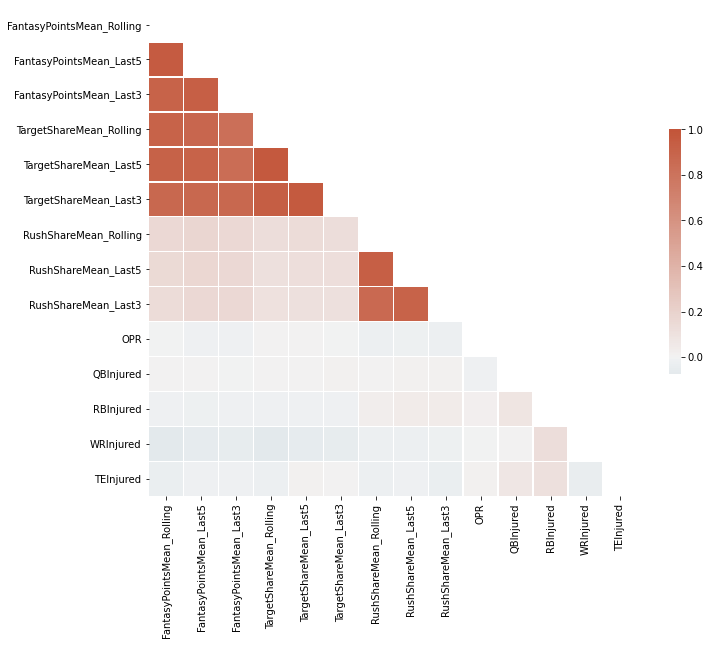

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

frames = [WR2019, WR2020]
frame = pd.concat(frames, ignore_index = True)

df = frame[['FantasyPointsMean_Rolling','FantasyPointsMean_Last5','FantasyPointsMean_Last3','TargetShareMean_Rolling','TargetShareMean_Last5','TargetShareMean_Last3','RushShareMean_Rolling','RushShareMean_Last5','RushShareMean_Last3','OPR','QBInjured','RBInjured','WRInjured','TEInjured']]
correlation = df.corr()
mask = np.triu(np.ones_like(correlation , dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.5})

<AxesSubplot:>

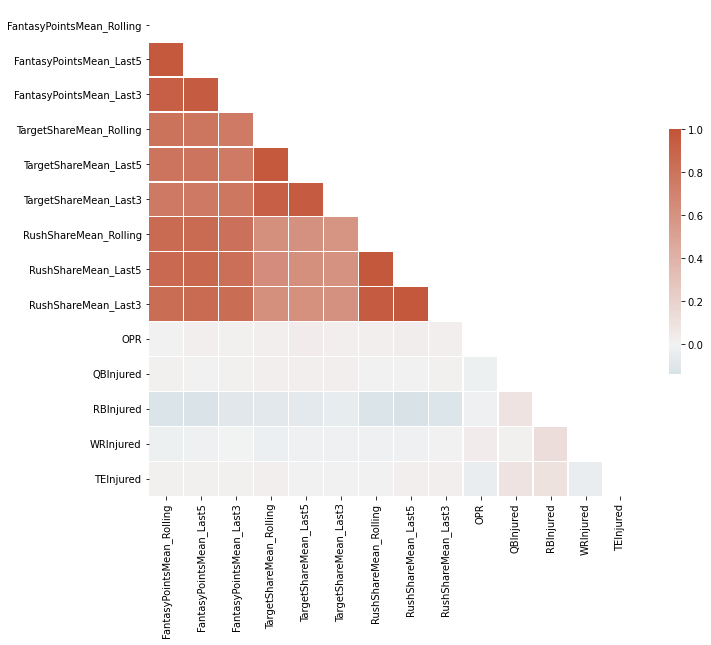

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns

frames = [RB2019, RB2020]
frame = pd.concat(frames, ignore_index = True)

df = frame[['FantasyPointsMean_Rolling','FantasyPointsMean_Last5','FantasyPointsMean_Last3','TargetShareMean_Rolling','TargetShareMean_Last5','TargetShareMean_Last3','RushShareMean_Rolling','RushShareMean_Last5','RushShareMean_Last3','OPR','QBInjured','RBInjured','WRInjured','TEInjured']]
correlation = df.corr()
mask = np.triu(np.ones_like(correlation , dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.5})

<AxesSubplot:>

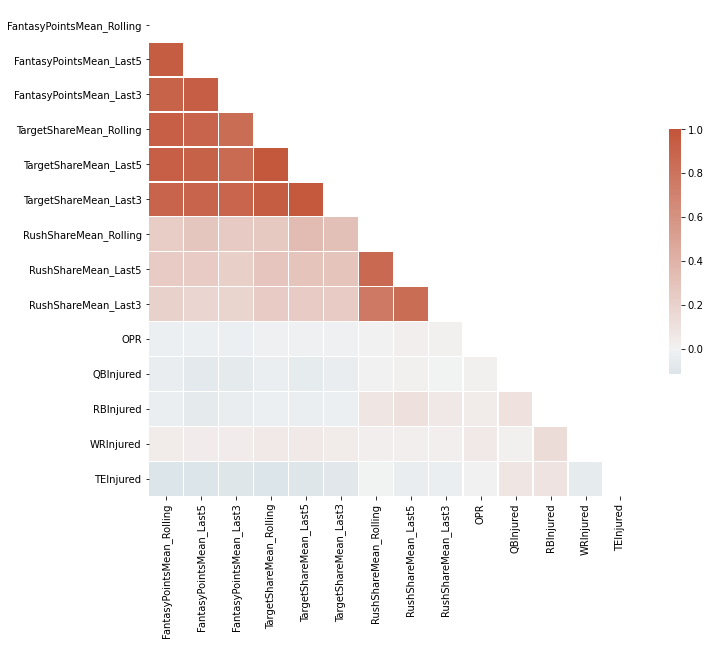

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

frames = [TE2019, TE2020]
frame = pd.concat(frames, ignore_index = True)

df = frame[['FantasyPointsMean_Rolling','FantasyPointsMean_Last5','FantasyPointsMean_Last3','TargetShareMean_Rolling','TargetShareMean_Last5','TargetShareMean_Last3','RushShareMean_Rolling','RushShareMean_Last5','RushShareMean_Last3','OPR','QBInjured','RBInjured','WRInjured','TEInjured']]
correlation = df.corr()
mask = np.triu(np.ones_like(correlation , dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.5})

<AxesSubplot:>

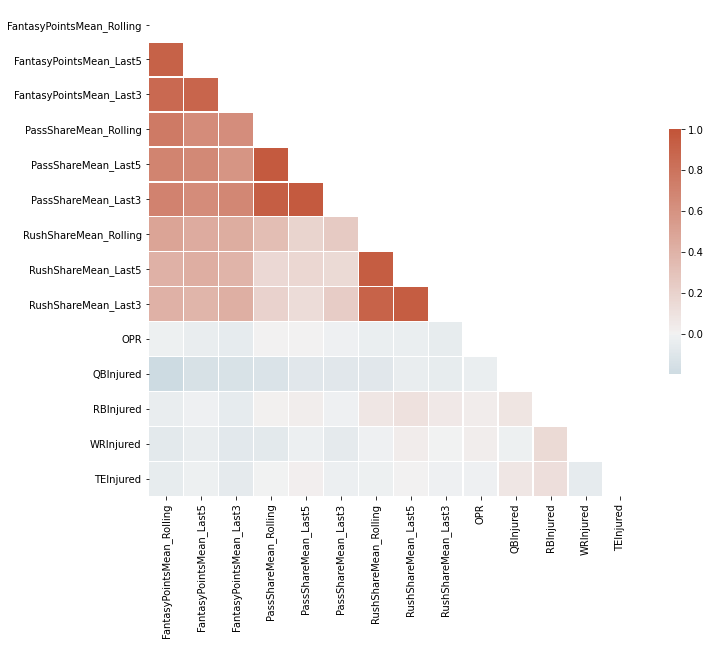

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

frames = [QB2019, QB2020]
frame = pd.concat(frames, ignore_index = True)

df = frame[['FantasyPointsMean_Rolling','FantasyPointsMean_Last5','FantasyPointsMean_Last3','PassShareMean_Rolling','PassShareMean_Last5','PassShareMean_Last3','RushShareMean_Rolling','RushShareMean_Last5','RushShareMean_Last3','OPR','QBInjured','RBInjured','WRInjured','TEInjured']]
correlation = df.corr()
mask = np.triu(np.ones_like(correlation , dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.5})

In [154]:
QB2021.FantasyPoints_Ou32rPrediction.mean()

17.999416038877314

In [151]:
WR2021.FantasyPoints_OurPrediction.mean()

7.5756389102281005

In [152]:
RB2021.FantasyPoints_OurPrediction.mean()

7.322626484188996

In [153]:
TE2021.FantasyPoints_OurPrediction.mean()

4.690610932969012

In [155]:
DST2021.FantasyPoints_OurPrediction.mean()

7.0160102563976965

### Comparison to Real Lineups

In [108]:
### Load Regression Data - avoids players becoming unavailable in certain weeks

QB2021 = pd.read_csv("~/Desktop/MGSC 434 Final Project/Regression Data/QB2021.csv")
RB2021 = pd.read_csv("~/Desktop/MGSC 434 Final Project/Regression Data/RB2021.csv")
WR2021 = pd.read_csv("~/Desktop/MGSC 434 Final Project/Regression Data/WR2021.csv")
TE2021 = pd.read_csv("~/Desktop/MGSC 434 Final Project/Regression Data/TE2021.csv")
DST2021 = pd.read_csv("~/Desktop/MGSC 434 Final Project/Regression Data/DST2021.csv")

QB2021 = QB2021[['Name','Position','Week','Team','Opponent','Salary','FantasyPoints']]
RB2021 = RB2021[['Name','Position','Week','Team','Opponent','Salary','FantasyPoints']]
WR2021 = WR2021[['Name','Position','Week','Team','Opponent','Salary','FantasyPoints']]
TE2021 = TE2021[['Name','Position','Week','Team','Opponent','Salary','FantasyPoints']]
DST2021 = DST2021[['Name','Position','Week','Team','Opponent','Salary','FantasyPoints']]

all_players = pd.concat([QB2021, RB2021, WR2021, TE2021, DST2021])

In [109]:
### Function: Create a lineuo from scratch
def lineup(week, qb, rb1, rb2, wr1, wr2, wr3, te, flex, dst):
    
    frames = []
    
    df = all_players[all_players.Week == week]
    
    frames.append(df[df.Name == qb])
    frames.append(df[df.Name == rb1])
    frames.append(df[df.Name == rb2])
    frames.append(df[df.Name == wr1])
    frames.append(df[df.Name == wr2])
    frames.append(df[df.Name == wr3])
    frames.append(df[df.Name == te])
    frames.append(df[df.Name == flex])
    frames.append(df[df.Name == dst])
    
    frame = pd.concat(frames)
    return frame

### Chris Pennell (Average Player)

In [110]:
dfs = []

In [111]:
dfs.append(lineup(6, 'Taylor Heinicke', 'Kareem Hunt', 'Darrell Henderson Jr.', "Davante Adams", 'Tee Higgins', 'Jakobi Meyers', 'Ricky Seals-Jones', 'Jonathan Taylor', 'Kansas City Chiefs'))
dfs.append(lineup(7, 'Lamar Jackson', 'Darrell Henderson Jr.', "Darrel Williams", 'Calvin Ridley', 'Rashod Bateman', 'Chris Godwin', 'Ricky Seals-Jones', 'Aaron Jones', 'Philadelphia Eagles'))
dfs.append(lineup(8, 'Jalen Hurts', 'Darrell Henderson Jr.', "D'Andre Swift", 'Chris Godwin', 'Michael Pittman Jr.', 'Tee Higgins', 'Dan Arnold', 'James Robinson', 'Washington Commanders'))
dfs.append(lineup(9, 'Lamar Jackson', 'Austin Ekeler', "Ezekiel Elliott", 'Amari Cooper', 'Hunter Renfrow', 'Tee Higgins', 'Tyler Conklin', 'Brandin Cooks', 'San Francisco 49ers'))
dfs.append(lineup(10, 'Dak Prescott', 'Najee Harris', "D'Ernest Johnson", 'Amari Cooper', 'Michael Pittman Jr.', 'Cole Beasley', 'Dan Arnold', 'Leonard Fournette', 'Tennessee Titans'))
dfs.append(lineup(11, 'Patrick Mahomes', 'AJ Dillon', "Jeff Wilson Jr.", 'Tyreek Hill', 'Michael Gallup', 'Tee Higgins', 'Dan Arnold', 'James Conner', 'Cleveland Browns'))
dfs.append(lineup(12, 'Cam Newton', 'James Robinson', "Miles Sanders", 'Chris Godwin', 'Michael Pittman Jr.', 'Diontae Johnson', 'Jared Cook', 'Davante Adams', 'Houston Texans'))
dfs.append(lineup(13, 'Tom Brady', 'Elijah Mitchell', "Antonio Gibson", 'Cooper Kupp', 'DeVante Parker', 'Chris Godwin', 'Foster Moreau', 'Jamaal Williams', 'Miami Dolphins'))
dfs.append(lineup(14, 'Taysom Hill', 'Austin Ekeler', "Antonio Gibson", 'Hunter Renfrow', 'Mike Williams', 'Amari Cooper', "James O'Shaughnessy", 'Javonte Williams', 'Seattle Seahawks'))
dfs.append(lineup(15, 'Dak Prescott', 'James Robinson', "Michael Carter", 'Davante Adams', 'DeVante Parker', 'Gabriel Davis', "George Kittle", 'Myles Gaskin', 'Buffalo Bills'))
dfs.append(lineup(16, 'Matthew Stafford', 'James Robinson', "Ronald Jones II", 'Cooper Kupp', 'Antonio Brown', 'Justin Jefferson', "Cole Kmet", 'Justin Jackson', 'Atlanta Falcons'))
dfs.append(lineup(17, 'Trey Lance', 'David Montgomery', "Sony Michel", 'Antonio Brown', 'Cooper Kupp', 'Brandin Cooks', "C.J. Uzomah", 'Jaret Patterson', 'Chicago Bears'))        

In [112]:
### Ouputs selected lineups for each week and stores total fantasy points for each week in a list
fantasy_points_this_model = []
for i in range(0,len(dfs)):
    display(dfs[i])
    fantasy_points_this_model.append(dfs[i].FantasyPoints.sum())
fantasy_points_all_models.append(fantasy_points_this_model)

,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
220,Taylor Heinicke,QB,6,WAS,KC,5800.0,10.28
609,Kareem Hunt,RB,6,CLE,ARI,6200.0,10.80
591,Darrell Henderson Jr.,RB,6,LAR,NYG,6000.0,24.70
865,Davante Adams,WR,6,GB,CHI,9000.0,12.90
895,Tee Higgins,WR,6,CIN,DET,5300.0,7.40
874,Jakobi Meyers,WR,6,NE,DAL,5500.0,11.40
492,Ricky Seals-Jones,TE,6,WAS,KC,3000.0,15.80
586,Jonathan Taylor,RB,6,IND,HOU,6600.0,31.80
170,Kansas City Chiefs,DST,6,KC,WAS,2800.0,8.00


,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
237,Lamar Jackson,QB,7,BAL,CIN,7400.0,23.08
717,Darrell Henderson Jr.,RB,7,LAR,DET,6600.0,9.40
719,Darrel Williams,RB,7,KC,TEN,5800.0,8.00
1018,Calvin Ridley,WR,7,ATL,MIA,6600.0,12.60
1023,Rashod Bateman,WR,7,BAL,CIN,3400.0,11.00
995,Chris Godwin,WR,7,TB,CHI,5900.0,28.10
579,Ricky Seals-Jones,TE,7,WAS,GB,3700.0,11.10
718,Aaron Jones,RB,7,GB,WAS,7500.0,8.90
209,Philadelphia Eagles,DST,7,PHI,LV,2300.0,1.00


,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
290,Jalen Hurts,QB,8,PHI,DET,7200.0,11.22
784,Darrell Henderson Jr.,RB,8,LAR,HOU,6500.0,22.30
810,D'Andre Swift,RB,8,DET,PHI,7100.0,9.10
1130,Chris Godwin,WR,8,TB,NO,6400.0,31.00
1131,Michael Pittman Jr.,WR,8,IND,TEN,5300.0,30.60
1153,Tee Higgins,WR,8,CIN,NYJ,5200.0,13.70
650,Dan Arnold,TE,8,JAX,SEA,2800.0,14.80
829,James Robinson,RB,8,JAX,SEA,6600.0,4.90
227,Washington Commanders,DST,8,WAS,DEN,2100.0,7.00


,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
304,Lamar Jackson,QB,9,BAL,MIN,7300.0,35.64
912,Austin Ekeler,RB,9,LAC,PHI,7900.0,11.20
908,Ezekiel Elliott,RB,9,DAL,DEN,7000.0,12.60
1342,Amari Cooper,WR,9,DAL,DEN,5700.0,5.70
1293,Hunter Renfrow,WR,9,LV,NYG,4800.0,17.90
1301,Tee Higgins,WR,9,CIN,CLE,5300.0,13.80
754,Tyler Conklin,TE,9,MIN,BAL,3000.0,9.50
1305,Brandin Cooks,WR,9,HOU,MIA,6100.0,11.60
266,San Francisco 49ers,DST,9,SF,ARI,2800.0,1.00


,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
344,Dak Prescott,QB,10,DAL,ATL,6900.0,26.34
994,Najee Harris,RB,10,PIT,DET,7900.0,20.30
989,D'Ernest Johnson,RB,10,CLE,NE,4700.0,22.70
1474,Amari Cooper,WR,10,DAL,ATL,6200.0,9.10
1463,Michael Pittman Jr.,WR,10,IND,JAX,6300.0,12.10
1507,Cole Beasley,WR,10,BUF,NYJ,5200.0,3.50
829,Dan Arnold,TE,10,JAX,IND,3500.0,13.70
999,Leonard Fournette,RB,10,TB,WAS,6100.0,17.20
284,Tennessee Titans,DST,10,TEN,NO,2600.0,6.00


,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
407,Patrick Mahomes,QB,11,KC,DAL,7600.0,9.5
1097,AJ Dillon,RB,11,GB,MIN,6200.0,15.7
1115,Jeff Wilson Jr.,RB,11,SF,JAX,5100.0,6.8
1597,Tyreek Hill,WR,11,KC,DAL,8200.0,20.0
1621,Michael Gallup,WR,11,DAL,KC,4200.0,9.4
1659,Tee Higgins,WR,11,CIN,LV,5400.0,3.5
960,Dan Arnold,TE,11,JAX,SF,4100.0,0.0
1091,James Conner,RB,11,ARI,SEA,6100.0,20.9
313,Cleveland Browns,DST,11,CLE,DET,3100.0,8.0


,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
450,Cam Newton,QB,12,CAR,MIA,5600.0,8.18
1212,James Robinson,RB,12,JAX,ATL,6200.0,13.50
1227,Miles Sanders,RB,12,PHI,NYG,5100.0,7.40
1797,Chris Godwin,WR,12,TB,IND,7000.0,5.70
1777,Michael Pittman Jr.,WR,12,IND,TB,5600.0,9.30
1753,Diontae Johnson,WR,12,PIT,CIN,6600.0,18.50
1010,Jared Cook,TE,12,LAC,DEN,3000.0,10.50
1744,Davante Adams,WR,12,GB,LAR,8600.0,21.40
343,Houston Texans,DST,12,HOU,NYJ,2300.0,6.00


,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
460,Tom Brady,QB,13,TB,ATL,7200.0,32.62
1317,Elijah Mitchell,RB,13,SF,SEA,6000.0,17.40
1308,Antonio Gibson,RB,13,WAS,LV,5700.0,22.10
1899,Cooper Kupp,WR,13,LAR,JAX,9000.0,29.90
1923,DeVante Parker,WR,13,MIA,NYG,3900.0,11.20
1897,Chris Godwin,WR,13,TB,ATL,6600.0,33.20
1113,Foster Moreau,TE,13,LV,WAS,2700.0,4.40
1328,Jamaal Williams,RB,13,DET,MIN,5400.0,9.00
369,Miami Dolphins,DST,13,MIA,NYG,3300.0,9.00


,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
498,Taysom Hill,QB,14,NO,NYJ,5600.0,26.3
1416,Austin Ekeler,RB,14,LAC,NYG,8300.0,16.4
1444,Antonio Gibson,RB,14,WAS,DAL,6000.0,5.1
2045,Hunter Renfrow,WR,14,LV,KC,6100.0,32.7
2082,Mike Williams,WR,14,LAC,NYG,6000.0,12.1
2065,Amari Cooper,WR,14,DAL,WAS,5900.0,16.1
1195,James O'Shaughnessy,TE,14,JAX,TEN,2900.0,6.1
1412,Javonte Williams,RB,14,DEN,DET,5900.0,21.3
399,Seattle Seahawks,DST,14,SEA,HOU,3100.0,6.0


,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
552,Dak Prescott,QB,15,DAL,NYG,6500.0,11.58
1511,James Robinson,RB,15,JAX,HOU,5400.0,17.80
1565,Michael Carter,RB,15,NYJ,MIA,4700.0,3.00
2203,Davante Adams,WR,15,GB,BAL,8900.0,16.40
2202,DeVante Parker,WR,15,MIA,NYJ,4300.0,16.80
2192,Gabriel Davis,WR,15,BUF,CAR,3700.0,25.50
1264,George Kittle,TE,15,SF,ATL,7500.0,15.30
1551,Myles Gaskin,RB,15,MIA,NYJ,5600.0,5.40
430,Buffalo Bills,DST,15,BUF,CAR,3100.0,7.00


,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
595,Matthew Stafford,QB,16,LAR,MIN,6700.0,9.68
1699,James Robinson,RB,16,JAX,NYJ,5900.0,1.00
1634,Ronald Jones II,RB,16,TB,CAR,5100.0,16.10
2367,Cooper Kupp,WR,16,LAR,MIN,9100.0,24.30
2368,Antonio Brown,WR,16,TB,CAR,4900.0,23.10
2369,Justin Jefferson,WR,16,MIN,LAR,8100.0,22.60
1370,Cole Kmet,TE,16,CHI,SEA,3300.0,8.90
1622,Justin Jackson,RB,16,LAC,HOU,4200.0,35.20
471,Atlanta Falcons,DST,16,ATL,DET,2600.0,3.00


,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
623,Trey Lance,QB,17,SF,HOU,4800.0,20.06
1748,David Montgomery,RB,17,CHI,NYG,6500.0,21.10
1752,Sony Michel,RB,17,LAR,BAL,5800.0,18.90
2592,Antonio Brown,WR,17,TB,NYJ,6100.0,5.60
2532,Cooper Kupp,WR,17,LAR,BAL,9500.0,21.50
2538,Brandin Cooks,WR,17,HOU,SF,6000.0,19.60
1467,C.J. Uzomah,TE,17,CIN,KC,3300.0,7.20
1750,Jaret Patterson,RB,17,WAS,PHI,4800.0,20.80
480,Chicago Bears,DST,17,CHI,NYG,3200.0,21.00


### Winning Lineups

In [113]:
dfs = [] 

In [114]:
dfs.append(lineup(7, "Matthew Stafford", "D'Andre Swift", "Damien Harris", "Chris Godwin", "Cooper Kupp", "Terry McLaurin", "Foster Moreau", "Van Jefferson", "Tampa Bay Buccaneers"))
dfs.append(lineup(8, 'Carson Wentz', "Elijah Mitchell", "Michael Carter", 'A.J. Brown', 'Cooper Kupp', 'Michael Pittman Jr.', 'Pat Freiermuth', 'Chris Godwin', 'Seattle Seahawks'))
dfs.append(lineup(9, 'Justin Herbert', 'Nick Chubb', "Zack Moss", 'Jaylen Waddle', 'Keenan Allen', 'Marquise Brown', 'Mike Gesicki', 'James Conner', 'Cleveland Browns'))
dfs.append(lineup(10, "Josh Allen", "D'Ernest Johnson", "Mark Ingram II", "CeeDee Lamb", "Keenan Allen", "Stefon Diggs", "Hunter Henry", "Rhamondre Stevenson", "Philadelphia Eagles"))
dfs.append(lineup(11, "Cam Newton", "Jonathan Taylor", "Miles Sanders", "Elijah Moore", "Justin Jefferson", "Terry McLaurin", "Tommy Tremble", "D'Andre Swift", "Detroit Lions"))
dfs.append(lineup(12, "Matthew Stafford", "Joe Mixon", "Leonard Fournette", "Jaylen Waddle", "Robby Anderson", "Odell Beckham Jr.", "Rob Gronkowski", "Darrell Henderson Jr.", "Miami Dolphins"))
dfs.append(lineup(13, "Gardner Minshew", "Jamaal Williams", "Sony Michel", "Chris Godwin", "Diontae Johnson", "Justin Jefferson", "George Kittle", "Dallas Goedert", "Los Angeles Rams"))
dfs.append(lineup(14, "Josh Allen", "Rashaad Penny", "Saquon Barkley", "Cole Beasley", "Ja'Marr Chase", "Robby Anderson", "Mark Andrews", "Hunter Renfrow", "Seattle Seahawks"))
dfs.append(lineup(15, "Tyler Huntley", "D'Onta Foreman", "Jeff Wilson Jr.", "Brandin Cooks", "Christian Kirk", "Amon-Ra St. Brown", "Mark Andrews", "Davante Adams", "Houston Texans"))
dfs.append(lineup(16, "Joe Burrow", "Joe Mixon", "Justin Jackson", "Braxton Berrios", "Ja'Marr Chase", "Tee Higgins", "Mark Andrews", "Damien Harris", "Philadelphia Eagles"))
dfs.append(lineup(17, "Russell Wilson", "David Montgomery", "Jaret Patterson", "DK Metcalf", "Tyler Lockett", "Amon-Ra St. Brown", "Tyler Higbee", "Rashaad Penny", "New Orleans Saints"))

In [115]:
### Ouputs selected lineups for each week and stores total fantasy points for each week in a list
fantasy_points_this_model = [np.nan] # Week 6 is unavailable
for i in range(0,len(dfs)):
    display(dfs[i])
    fantasy_points_this_model.append(dfs[i].FantasyPoints.sum())
fantasy_points_all_models.append(fantasy_points_this_model)

,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
231,Matthew Stafford,QB,7,LAR,DET,7100.0,30.16
688,D'Andre Swift,RB,7,DET,LAR,6000.0,28.40
689,Damien Harris,RB,7,NE,NYJ,5700.0,28.30
995,Chris Godwin,WR,7,TB,CHI,5900.0,28.10
990,Cooper Kupp,WR,7,LAR,DET,8400.0,40.60
994,Terry McLaurin,WR,7,WAS,GB,6900.0,28.20
573,Foster Moreau,TE,7,LV,PHI,2500.0,18.00
1011,Van Jefferson,WR,7,LAR,DET,3500.0,14.30
188,Tampa Bay Buccaneers,DST,7,TB,CHI,4000.0,23.00


,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
277,Carson Wentz,QB,8,IND,TEN,5700.0,20.34
783,Elijah Mitchell,RB,8,SF,CHI,5400.0,22.70
779,Michael Carter,RB,8,NYJ,CIN,4900.0,32.20
1129,A.J. Brown,WR,8,TEN,IND,6900.0,34.50
1134,Cooper Kupp,WR,8,LAR,HOU,9000.0,27.50
1131,Michael Pittman Jr.,WR,8,IND,TEN,5300.0,30.60
651,Pat Freiermuth,TE,8,PIT,CLE,3600.0,14.40
1130,Chris Godwin,WR,8,TB,NO,6400.0,31.00
217,Seattle Seahawks,DST,8,SEA,JAX,2800.0,13.00


,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
305,Justin Herbert,QB,9,LAC,PHI,7000.0,34.64
888,Nick Chubb,RB,9,CLE,CIN,6700.0,33.30
936,Zack Moss,RB,9,BUF,JAX,5300.0,4.40
1299,Jaylen Waddle,WR,9,MIA,HOU,5600.0,16.30
1285,Keenan Allen,WR,9,LAC,PHI,6700.0,25.40
1286,Marquise Brown,WR,9,BAL,MIN,6000.0,23.60
756,Mike Gesicki,TE,9,MIA,HOU,4900.0,9.40
886,James Conner,RB,9,ARI,SF,5300.0,40.30
245,Cleveland Browns,DST,9,CLE,CIN,2500.0,18.00


,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
345,Josh Allen,QB,10,BUF,NYJ,7900.0,24.94
989,D'Ernest Johnson,RB,10,CLE,NE,4700.0,22.70
993,Mark Ingram II,RB,10,NO,TEN,4500.0,20.80
1435,CeeDee Lamb,WR,10,DAL,ATL,7000.0,28.60
1442,Keenan Allen,WR,10,LAC,MIN,7000.0,17.80
1433,Stefon Diggs,WR,10,BUF,NYJ,7500.0,33.20
824,Hunter Henry,TE,10,NE,CLE,4100.0,19.70
985,Rhamondre Stevenson,RB,10,NE,CLE,4500.0,30.40
276,Philadelphia Eagles,DST,10,PHI,DEN,2700.0,15.00


,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
388,Cam Newton,QB,11,CAR,WAS,5100.0,26.16
1084,Jonathan Taylor,RB,11,IND,BUF,8300.0,56.40
1109,Miles Sanders,RB,11,PHI,NO,5000.0,8.40
1584,Elijah Moore,WR,11,NYJ,MIA,4900.0,32.60
1582,Justin Jefferson,WR,11,MIN,GB,8100.0,40.20
1588,Terry McLaurin,WR,11,WAS,CAR,7000.0,24.30
932,Tommy Tremble,TE,11,CAR,WAS,2500.0,5.50
1087,D'Andre Swift,RB,11,DET,CLE,7000.0,25.60
309,Detroit Lions,DST,11,DET,CLE,2100.0,9.00


,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
424,Matthew Stafford,QB,12,LAR,GB,7100.0,26.98
1194,Joe Mixon,RB,12,CIN,PIT,7500.0,35.30
1193,Leonard Fournette,RB,12,TB,IND,6800.0,47.10
1738,Jaylen Waddle,WR,12,MIA,CAR,5900.0,31.70
1825,Robby Anderson,WR,12,CAR,MIA,4700.0,2.50
1750,Odell Beckham Jr.,WR,12,LAR,GB,5000.0,19.10
998,Rob Gronkowski,TE,12,TB,IND,4400.0,22.30
1206,Darrell Henderson Jr.,RB,12,LAR,GB,5800.0,17.30
330,Miami Dolphins,DST,12,MIA,CAR,2800.0,23.00


,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
470,Gardner Minshew,QB,13,PHI,NYJ,4000.0,18.78
1328,Jamaal Williams,RB,13,DET,MIN,5400.0,9.00
1305,Sony Michel,RB,13,LAR,JAX,4300.0,24.90
1897,Chris Godwin,WR,13,TB,ATL,6600.0,33.20
1896,Diontae Johnson,WR,13,PIT,BAL,6800.0,33.50
1895,Justin Jefferson,WR,13,MIN,DET,8200.0,38.60
1087,George Kittle,TE,13,SF,SEA,5900.0,42.60
1088,Dallas Goedert,TE,13,PHI,NYJ,4500.0,31.50
367,Los Angeles Rams,DST,13,LAR,JAX,4000.0,10.00


,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
494,Josh Allen,QB,14,BUF,TB,7800.0,42.22
1406,Rashaad Penny,RB,14,SEA,HOU,4800.0,29.80
1414,Saquon Barkley,RB,14,NYG,LAC,6000.0,18.50
2068,Cole Beasley,WR,14,BUF,TB,5000.0,15.40
2047,Ja'Marr Chase,WR,14,CIN,SF,6900.0,25.30
2049,Robby Anderson,WR,14,CAR,ATL,4300.0,21.40
1175,Mark Andrews,TE,14,BAL,CLE,5900.0,31.50
2045,Hunter Renfrow,WR,14,LV,KC,6100.0,32.70
399,Seattle Seahawks,DST,14,SEA,HOU,3100.0,6.00


,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
531,Tyler Huntley,QB,15,BAL,GB,5400.0,35.9
1509,D'Onta Foreman,RB,15,TEN,PIT,5200.0,18.5
1506,Jeff Wilson Jr.,RB,15,SF,ATL,5000.0,22.9
2191,Brandin Cooks,WR,15,HOU,JAX,5800.0,32.2
2193,Christian Kirk,WR,15,ARI,DET,5300.0,24.4
2194,Amon-Ra St. Brown,WR,15,DET,ARI,5200.0,23.5
1260,Mark Andrews,TE,15,BAL,GB,6400.0,38.6
2203,Davante Adams,WR,15,GB,BAL,8900.0,16.4
423,Houston Texans,DST,15,HOU,JAX,2800.0,10.0


,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
571,Joe Burrow,QB,16,CIN,BAL,5900.0,41.1
1624,Joe Mixon,RB,16,CIN,BAL,6900.0,31.5
1622,Justin Jackson,RB,16,LAC,HOU,4200.0,35.2
2383,Braxton Berrios,WR,16,NYJ,JAX,3500.0,15.0
2370,Ja'Marr Chase,WR,16,CIN,BAL,7100.0,22.5
2359,Tee Higgins,WR,16,CIN,BAL,6200.0,46.4
1355,Mark Andrews,TE,16,BAL,CIN,7000.0,29.5
1625,Damien Harris,RB,16,NE,BUF,5600.0,31.3
450,Philadelphia Eagles,DST,16,PHI,NYG,3600.0,16.0


,Name,Position,Week,Team,Opponent,Salary,FantasyPoints
615,Russell Wilson,QB,17,SEA,DET,6200.0,27.84
1748,David Montgomery,RB,17,CHI,NYG,6500.0,21.10
1750,Jaret Patterson,RB,17,WAS,PHI,4800.0,20.80
2529,DK Metcalf,WR,17,SEA,DET,6500.0,30.90
2559,Tyler Lockett,WR,17,SEA,DET,6400.0,12.10
2527,Amon-Ra St. Brown,WR,17,DET,SEA,6000.0,38.40
1457,Tyler Higbee,TE,17,LAR,BAL,4000.0,12.90
1738,Rashaad Penny,RB,17,SEA,DET,6100.0,35.50
481,New Orleans Saints,DST,17,NO,CAR,3400.0,15.00


### Pool Results

In [116]:
df = pd.DataFrame(fantasy_points_all_models).transpose()
df.columns = ['Our Predictions - Rules','Our Predictions - Constraints','DraftKings Projections - Rules','DraftKings Projections - Constraints','Chris Pennell','Winning Lineups']
df

,Our Predictions - Rules,Our Predictions - Constraints,DraftKings Projections - Rules,DraftKings Projections - Constraints,Chris Pennell,Winning Lineups
0,114.28,112.08,165.58,165.58,133.08,NaN
1,94.28,94.28,126.94,126.94,113.18,239.06
2,103.14,103.14,152.20,152.20,144.62,226.24
3,124.46,124.26,107.56,86.26,118.94,205.34
4,106.08,106.08,116.70,127.40,130.94,213.14
5,98.74,98.74,120.50,120.50,93.80,228.16
6,124.02,124.02,92.34,108.14,100.48,225.28
7,164.58,164.58,172.32,172.32,168.82,242.08
8,131.10,131.10,130.70,130.70,142.10,222.82
9,94.62,94.62,123.58,123.58,118.78,222.40


In [117]:
df.describe()

,Our Predictions - Rules,Our Predictions - Constraints,DraftKings Projections - Rules,DraftKings Projections - Constraints,Chris Pennell,Winning Lineups
count,12.000000,12.000000,12.000000,12.000000,12.000000,11.000000
mean,116.330000,115.796667,131.893333,131.886667,130.365000,227.960000
std,19.666349,19.634415,23.063286,23.574827,22.248891,17.160953
min,94.280000,94.280000,92.340000,86.260000,93.800000,205.340000
25%,102.040000,102.040000,119.550000,122.810000,117.380000,218.470000
50%,116.990000,114.520000,128.820000,129.050000,132.010000,225.280000
75%,124.130000,124.080000,141.670000,141.670000,144.065000,233.610000
max,164.580000,164.580000,172.320000,172.320000,168.820000,268.500000


In [118]:
df[df['Our Predictions - Rules'] > df['Our Predictions - Constraints']]

,Our Predictions - Rules,Our Predictions - Constraints,DraftKings Projections - Rules,DraftKings Projections - Constraints,Chris Pennell,Winning Lineups
0,114.28,112.08,165.58,165.58,133.08,NaN
3,124.46,124.26,107.56,86.26,118.94,205.34
10,120.96,116.96,136.14,130.86,143.88,268.50


In [119]:
df[df['Our Predictions - Rules'] < df['Our Predictions - Constraints']]

,Our Predictions - Rules,Our Predictions - Constraints,DraftKings Projections - Rules,DraftKings Projections - Constraints,Chris Pennell,Winning Lineups


In [120]:
df[df['Our Predictions - Rules'] == df['Our Predictions - Constraints']]

,Our Predictions - Rules,Our Predictions - Constraints,DraftKings Projections - Rules,DraftKings Projections - Constraints,Chris Pennell,Winning Lineups
1,94.28,94.28,126.94,126.94,113.18,239.06
2,103.14,103.14,152.20,152.20,144.62,226.24
4,106.08,106.08,116.70,127.40,130.94,213.14
5,98.74,98.74,120.50,120.50,93.80,228.16
6,124.02,124.02,92.34,108.14,100.48,225.28
7,164.58,164.58,172.32,172.32,168.82,242.08
8,131.10,131.10,130.70,130.70,142.10,222.82
9,94.62,94.62,123.58,123.58,118.78,222.40
11,119.70,119.70,138.16,138.16,155.76,214.54


In [121]:
df['Winning Lineups'] - df['Our Predictions - Constraints']

0        NaN
1     144.78
2     123.10
3      81.08
4     107.06
5     129.42
6     101.26
7      77.50
8      91.72
9     127.78
10    151.54
11     94.84
dtype: float64

In [122]:
df['Chris Pennell'] - df['Our Predictions - Constraints']

0     21.00
1     18.90
2     41.48
3     -5.32
4     24.86
5     -4.94
6    -23.54
7      4.24
8     11.00
9     24.16
10    26.92
11    36.06
dtype: float64